# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib
import pickle

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from src.lightgbm_wrapper.station_embedding import learn_station_embeddings, attach_station_embedding
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/joined_left_CMAQ.csv"
STATION_IDS = [201, 211, 212, 213, 214, 215, 216]

BASE_FEATURE_COLS = [
    "NO2_cmaq",
    "NO_cmaq",
    "O3_cmaq",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24, 48, 72]
ROLL_WINDOWS = [3, 6, 12, 24, 48, 72]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

model_path = "/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/no_testing_model"

# Load dataset

In [2]:
# Load dataset
df_all = pd.read_csv("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/joined_left_CMAQ.csv")

# Rename columns
df_all = df_all.rename({"Datetime": "date", "Station": "station_id"}, axis=1)
df_all = df_all.rename({c: c + "_cmaq" for c in df_all.columns if c not in ["date", "station_id"]}, axis=1)

# Set datetime
df_all["date"] = pd.to_datetime(df_all["date"])

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
print(df_all.dtypes)
df_all

(52332, 5)
Index(['date', 'NO2_cmaq', 'NO_cmaq', 'O3_cmaq', 'station_id'], dtype='object')
date          datetime64[ns]
NO2_cmaq             float64
NO_cmaq              float64
O3_cmaq              float64
station_id             int64
dtype: object


date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
0     2022-01-01 07:00:00  0.001115       NaN  0.098301         201
1     2022-01-01 08:00:00  0.001141       NaN  0.078072         201
2     2022-01-01 09:00:00  0.000941       NaN  0.061198         201
3     2022-01-01 10:00:00  0.000761       NaN  0.050983         201
4     2022-01-01 11:00:00  0.000600       NaN  0.042117         201
...                   ...       ...       ...       ...         ...
52327 2022-12-31 01:00:00  0.002276  0.000013  0.026421         216
52328 2022-12-31 02:00:00  0.002208  0.000013  0.026171         216
52329 2022-12-31 03:00:00  0.002249  0.000013  0.026087         216
52330 2022-12-31 04:00:00  0.002680  0.000013  0.026347         216
52331 2022-12-31 05:00:00  0.002590  0.000013  0.026102         216

[52332 rows x 5 columns]

In [3]:
df_all.isnull().sum()

date             0
NO2_cmaq         0
NO_cmaq       7637
O3_cmaq          0
station_id       0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
0     2022-01-02 00:00:00  0.006081  0.000046  0.026999         201
1     2022-01-02 01:00:00  0.005674  0.000046  0.026982         201
2     2022-01-02 02:00:00  0.005318  0.000046  0.027042         201
3     2022-01-02 03:00:00  0.005780  0.000046  0.026666         201
4     2022-01-02 04:00:00  0.006130  0.000046  0.026523         201
...                   ...       ...       ...       ...         ...
44690 2022-12-31 01:00:00  0.002276  0.000013  0.026421         216
44691 2022-12-31 02:00:00  0.002208  0.000013  0.026171         216
44692 2022-12-31 03:00:00  0.002249  0.000013  0.026087         216
44693 2022-12-31 04:00:00  0.002680  0.000013  0.026347         216
44694 2022-12-31 05:00:00  0.002590  0.000013  0.026102         216

[44695 rows x 5 columns]

In [5]:
for s in [211]:
    df_dropped = df_dropped.drop(index=df_dropped[df_dropped["station_id"] == s].index)
df_dropped = df_dropped.reset_index(drop=True)
df_dropped

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
0     2022-01-02 00:00:00  0.006081  0.000046  0.026999         201
1     2022-01-02 01:00:00  0.005674  0.000046  0.026982         201
2     2022-01-02 02:00:00  0.005318  0.000046  0.027042         201
3     2022-01-02 03:00:00  0.005780  0.000046  0.026666         201
4     2022-01-02 04:00:00  0.006130  0.000046  0.026523         201
...                   ...       ...       ...       ...         ...
38305 2022-12-31 01:00:00  0.002276  0.000013  0.026421         216
38306 2022-12-31 02:00:00  0.002208  0.000013  0.026171         216
38307 2022-12-31 03:00:00  0.002249  0.000013  0.026087         216
38308 2022-12-31 04:00:00  0.002680  0.000013  0.026347         216
38309 2022-12-31 05:00:00  0.002590  0.000013  0.026102         216

[38310 rows x 5 columns]

## Update the STATION_IDS after dropping missing

In [6]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[201, 212, 213, 214, 215, 216]

## Visualization

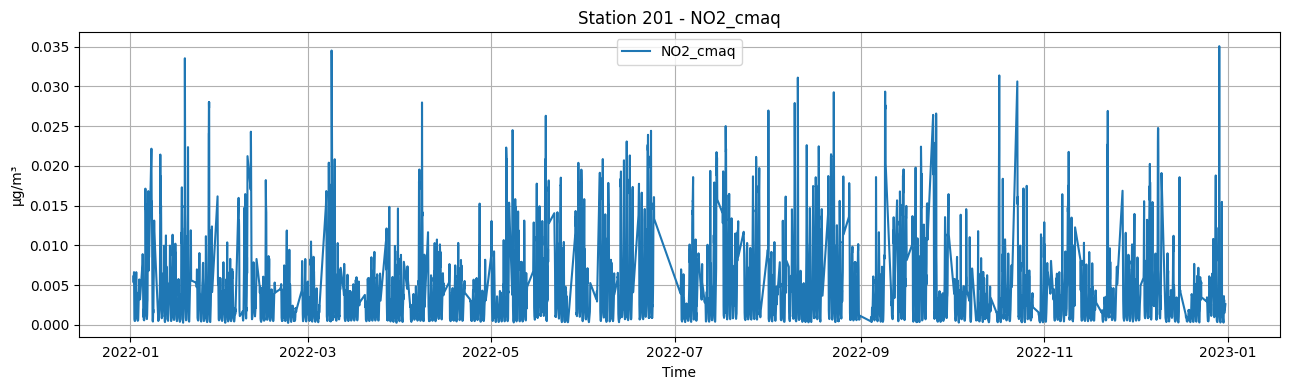

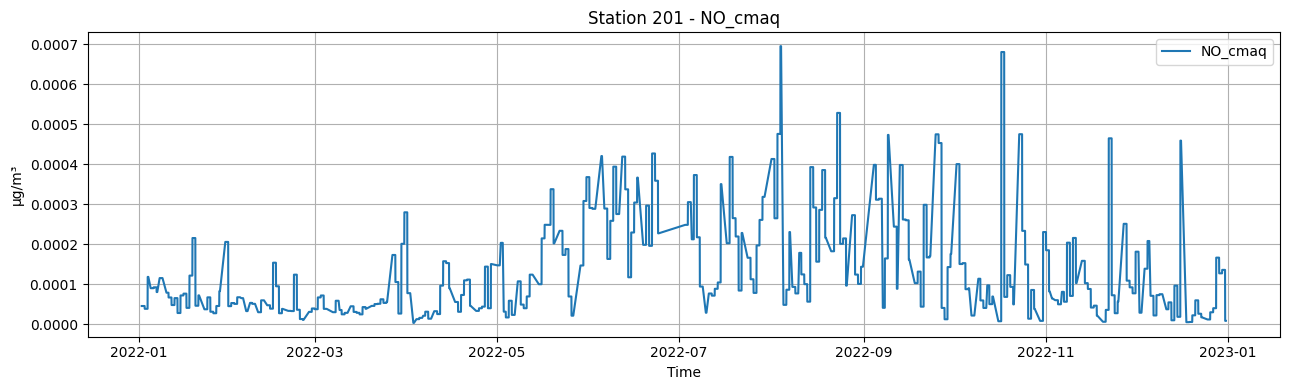

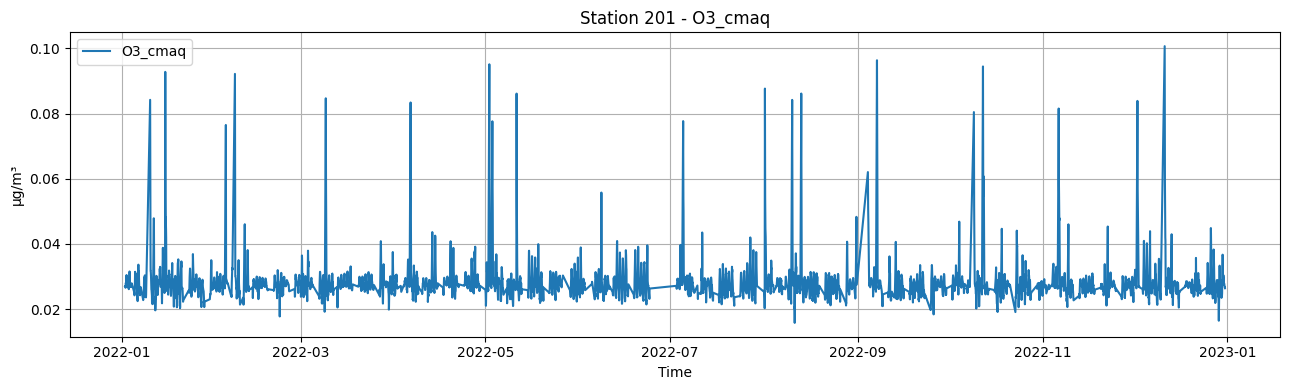

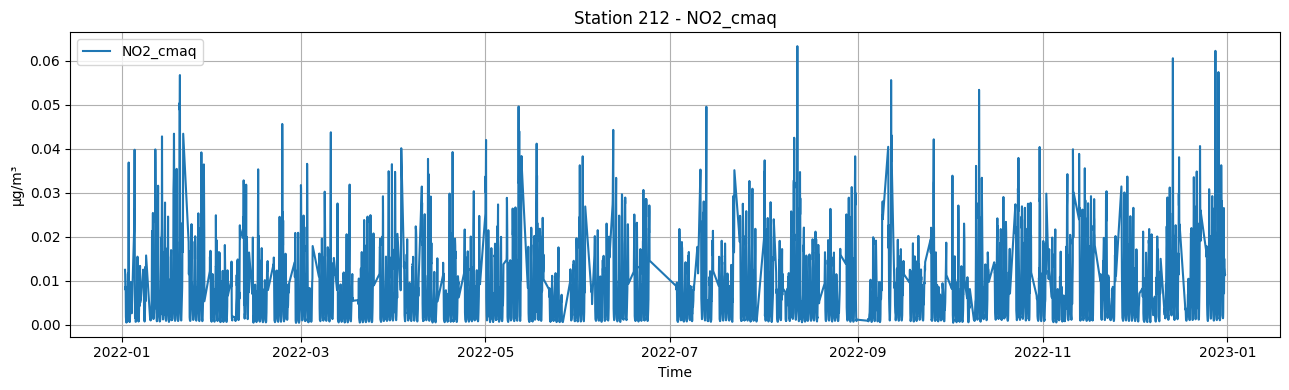

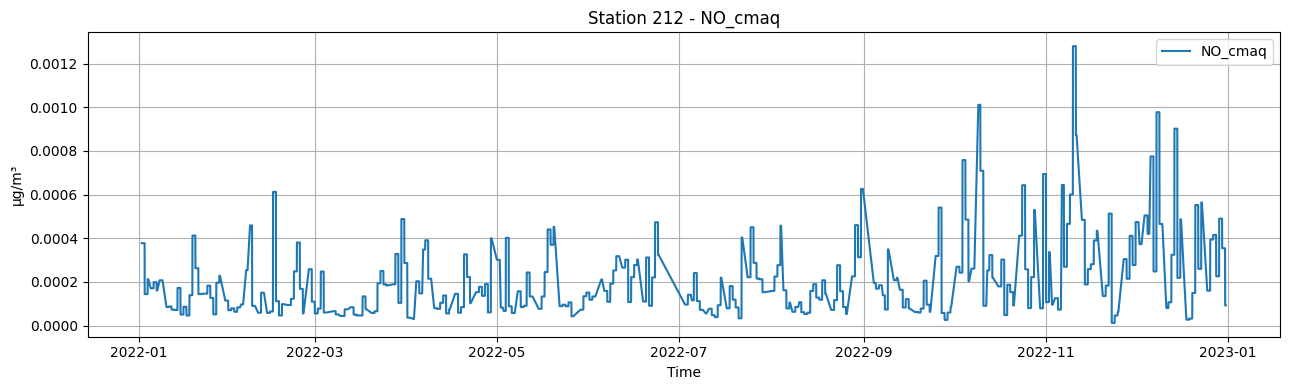

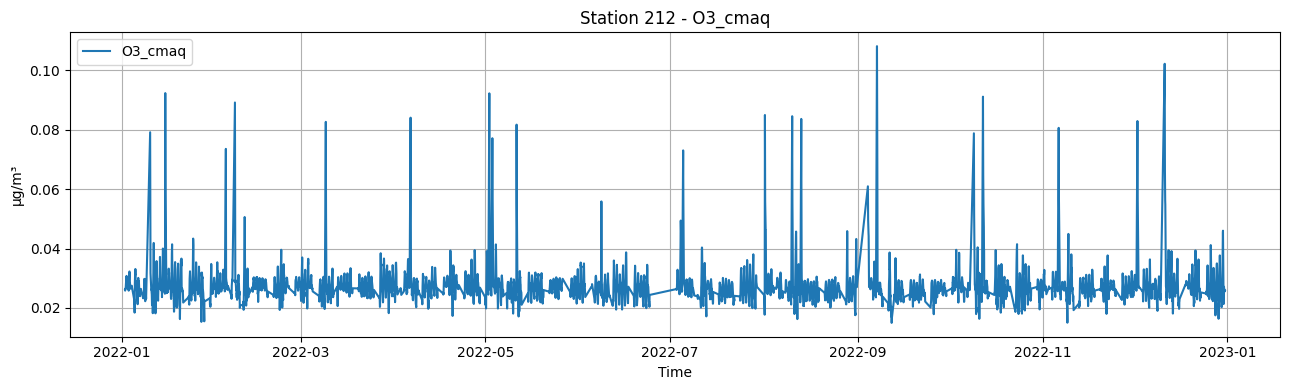

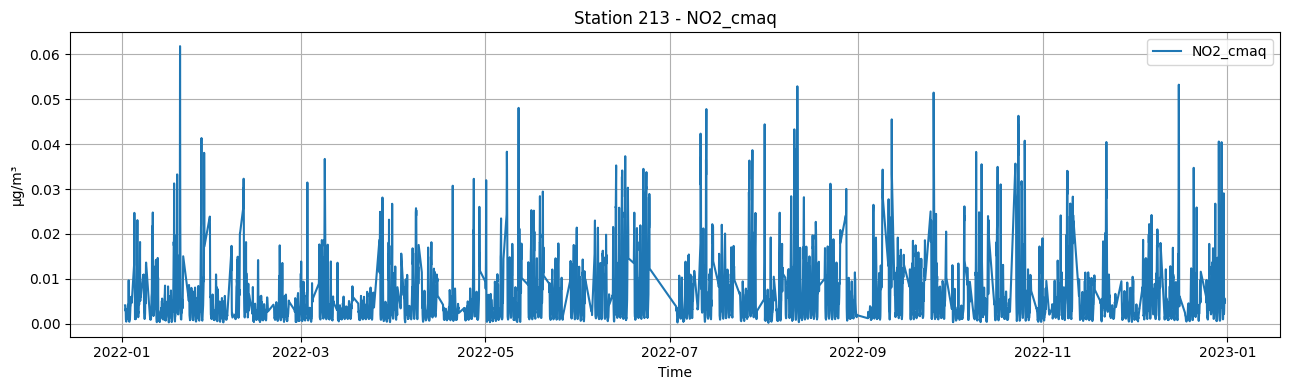

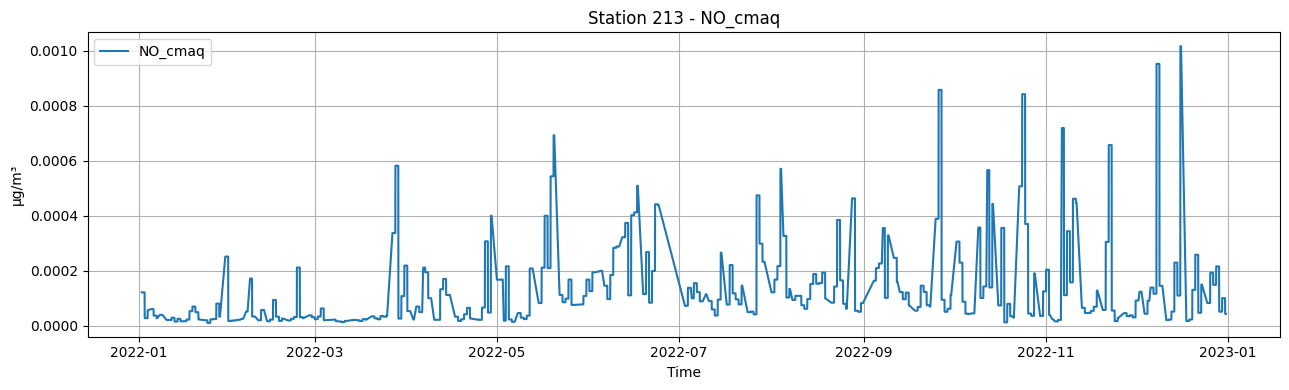

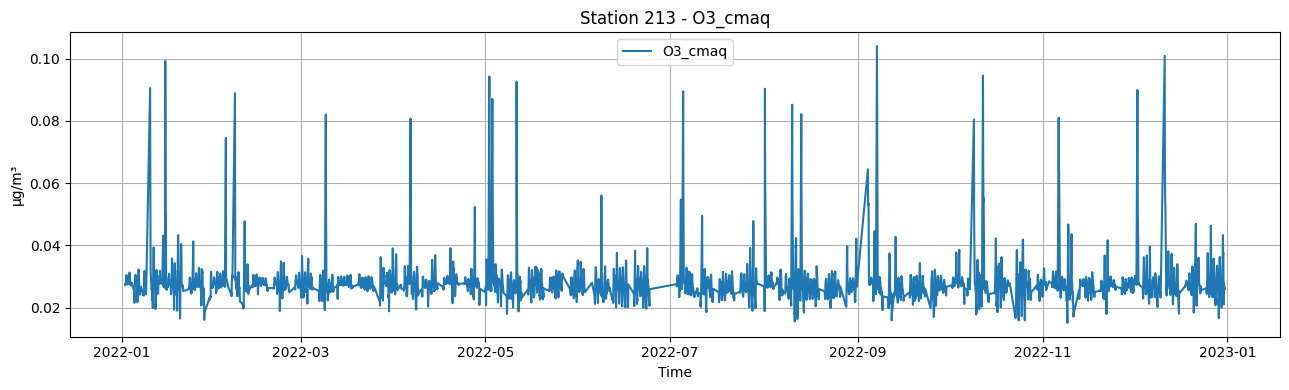

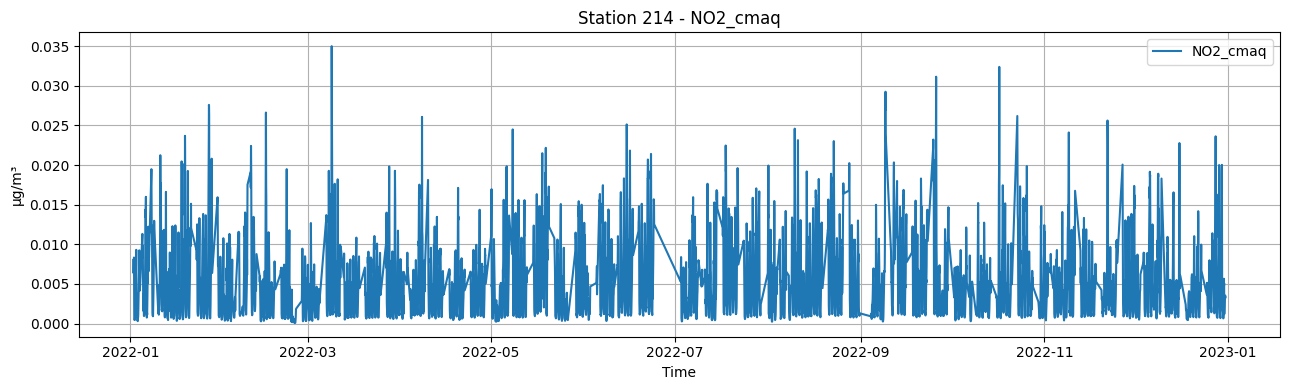

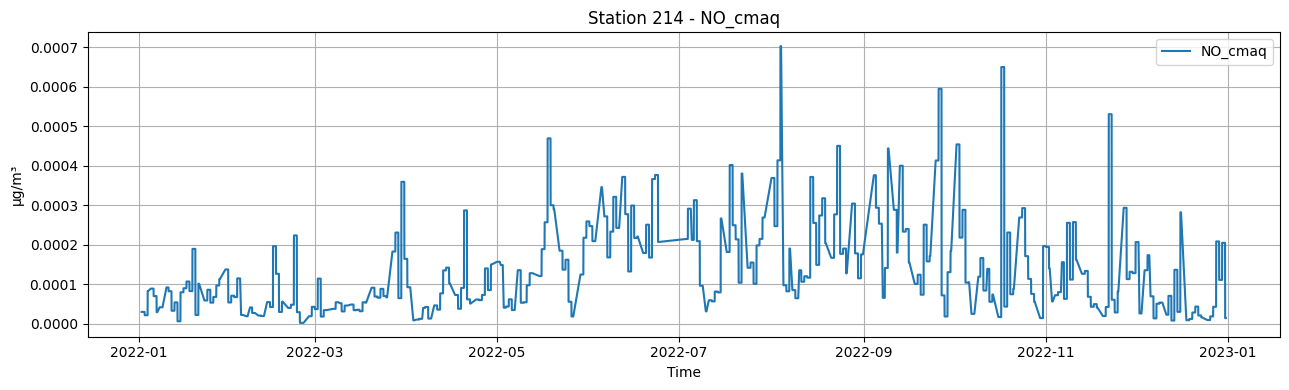

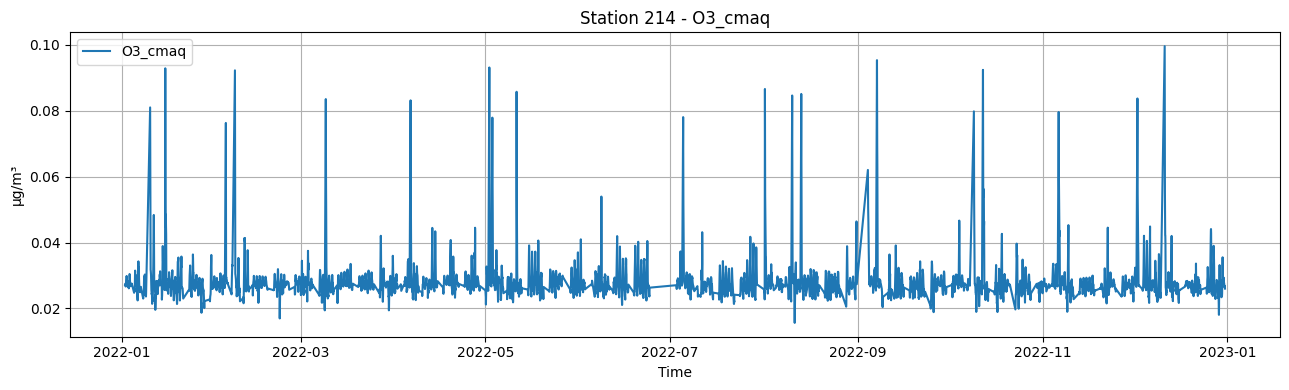

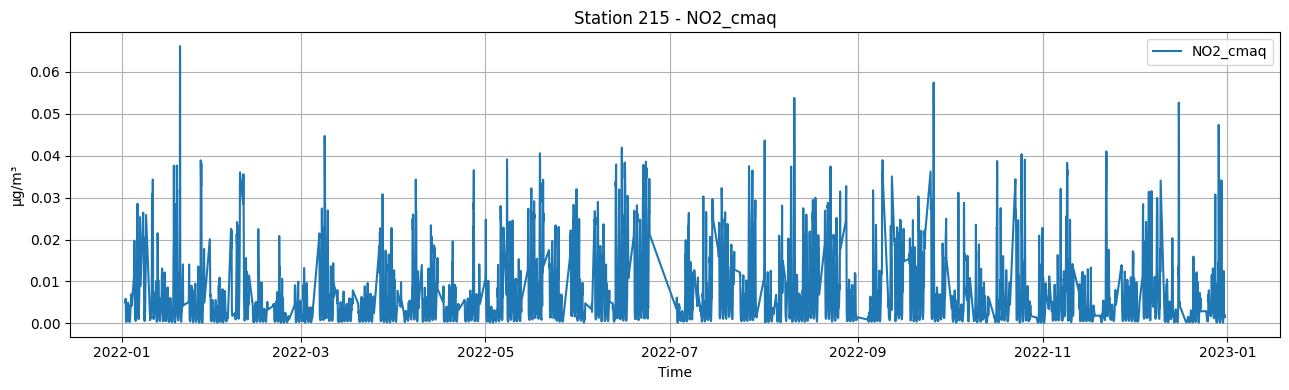

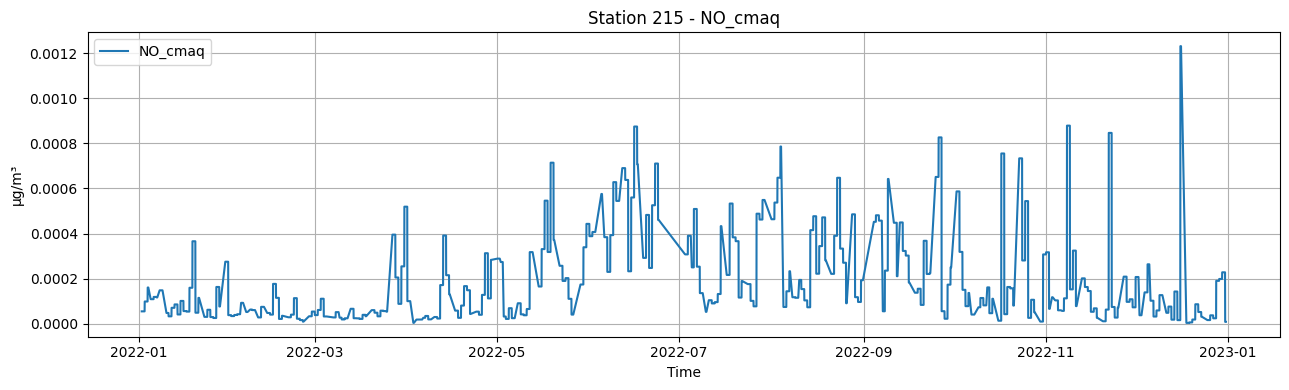

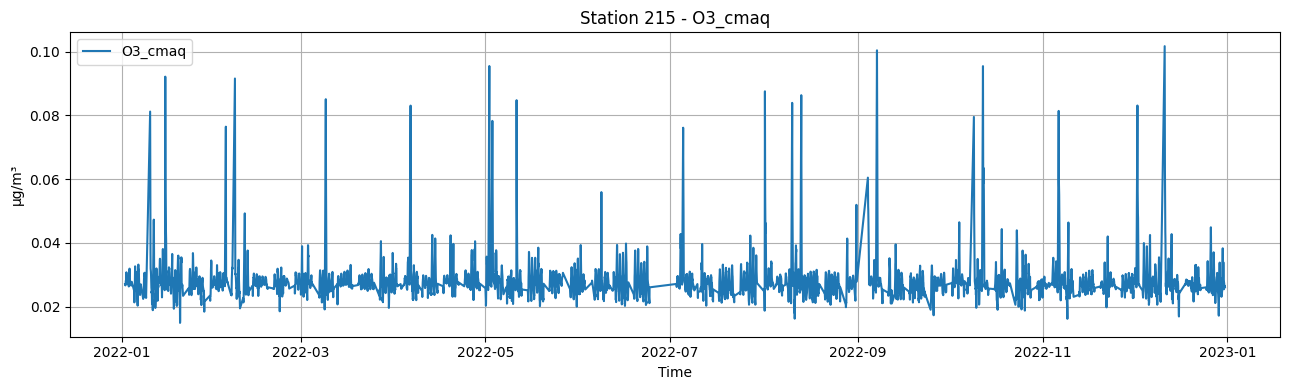

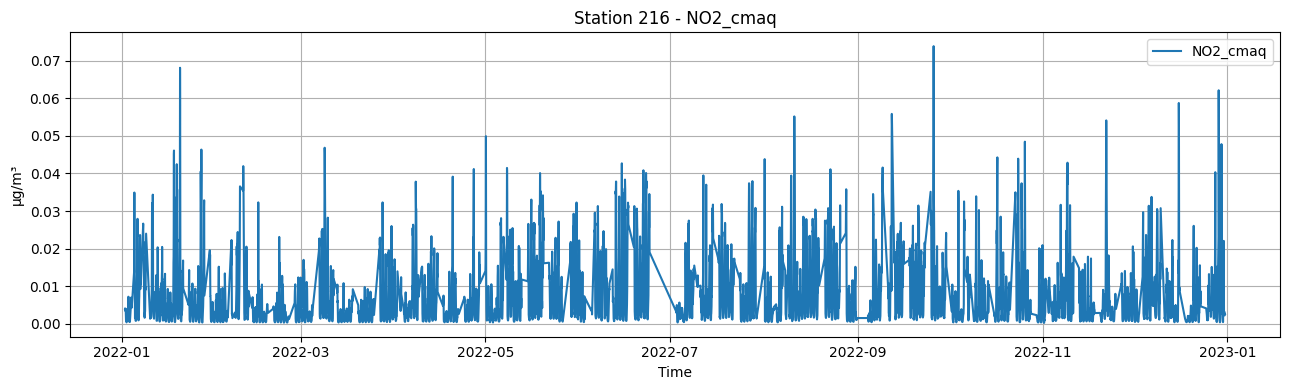

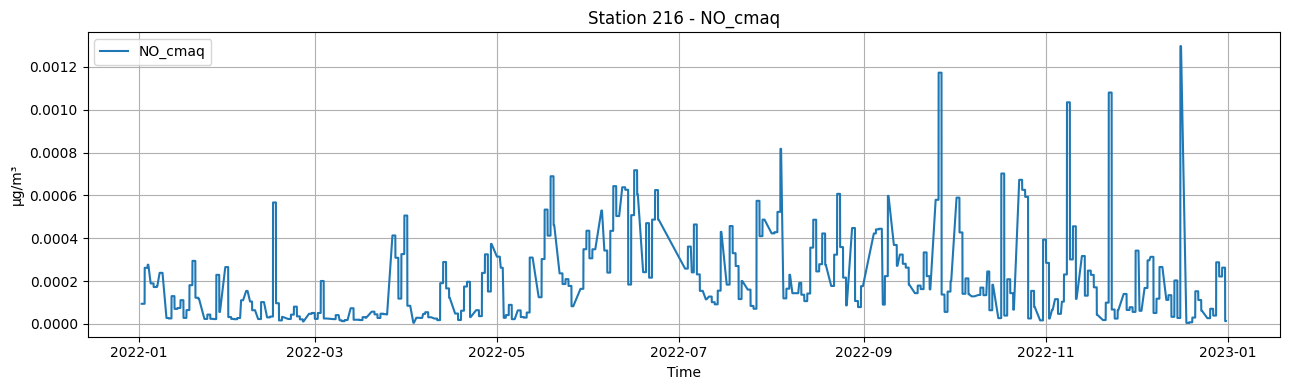

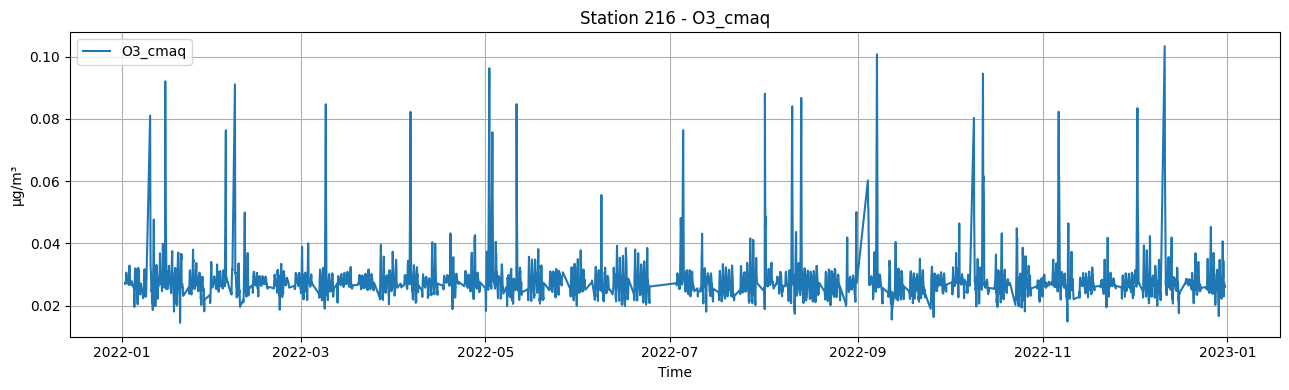

In [7]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [8]:
df_converted = copy.deepcopy(df_dropped)

print("=" * 50 + "BEFORE" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

df_converted = copy.deepcopy(df_dropped)
df_converted.loc[:, "NO2_cmaq"] = df_converted.loc[:, "NO2_cmaq"].apply(lambda x: x * 1883.2)
df_converted.loc[:, "O3_cmaq"] = df_converted.loc[:, "O3_cmaq"].apply(lambda x: x * 1963)
df_converted.loc[:, "NO_cmaq"] = df_converted.loc[:, "NO_cmaq"].apply(lambda x: x * 1228)

print("=" * 50 + "AFTER" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

==================================================BEFORE==================================================


date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
0    2022-01-02 00:00:00  0.006081  0.000046  0.026999         201
1    2022-01-02 01:00:00  0.005674  0.000046  0.026982         201
2    2022-01-02 02:00:00  0.005318  0.000046  0.027042         201
3    2022-01-02 03:00:00  0.005780  0.000046  0.026666         201
4    2022-01-02 04:00:00  0.006130  0.000046  0.026523         201
...                  ...       ...       ...       ...         ...
6380 2022-12-31 01:00:00  0.001994  0.000009  0.027238         201
6381 2022-12-31 02:00:00  0.002166  0.000009  0.026870         201
6382 2022-12-31 03:00:00  0.002358  0.000009  0.026731         201
6383 2022-12-31 04:00:00  0.002585  0.000009  0.026763         201
6384 2022-12-31 05:00:00  0.002589  0.000009  0.026382         201

[6385 rows x 5 columns]

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
6385  2022-01-02 00:00:00  0.012504  0.000377  0.025986         212
6386  2022-01-02 01:00:00  0.011679  0.000377  0.025817         212
6387  2022-01-02 02:00:00  0.008481  0.000377  0.026353         212
6388  2022-01-02 03:00:00  0.008012  0.000377  0.026370         212
6389  2022-01-02 04:00:00  0.008658  0.000377  0.026563         212
...                   ...       ...       ...       ...         ...
12765 2022-12-31 01:00:00  0.012712  0.000092  0.025961         212
12766 2022-12-31 02:00:00  0.012185  0.000092  0.025671         212
12767 2022-12-31 03:00:00  0.011695  0.000092  0.025531         212
12768 2022-12-31 04:00:00  0.011244  0.000092  0.025647         212
12769 2022-12-31 05:00:00  0.011360  0.000092  0.025819         212

[6385 rows x 5 columns]

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
12770 2022-01-02 00:00:00  0.004073  0.000122  0.027416         213
12771 2022-01-02 01:00:00  0.003839  0.000122  0.027204         213
12772 2022-01-02 02:00:00  0.003362  0.000122  0.027336         213
12773 2022-01-02 03:00:00  0.002904  0.000122  0.027401         213
12774 2022-01-02 04:00:00  0.002930  0.000122  0.027838         213
...                   ...       ...       ...       ...         ...
19150 2022-12-31 01:00:00  0.005501  0.000043  0.026384         213
19151 2022-12-31 02:00:00  0.005007  0.000043  0.026273         213
19152 2022-12-31 03:00:00  0.004596  0.000043  0.026267         213
19153 2022-12-31 04:00:00  0.004622  0.000043  0.026342         213
19154 2022-12-31 05:00:00  0.005120  0.000043  0.026079         213

[6385 rows x 5 columns]

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
19155 2022-01-02 00:00:00  0.008023  0.000030  0.027207         214
19156 2022-01-02 01:00:00  0.006365  0.000030  0.027311         214
19157 2022-01-02 02:00:00  0.006455  0.000030  0.027202         214
19158 2022-01-02 03:00:00  0.007830  0.000030  0.026857         214
19159 2022-01-02 04:00:00  0.008147  0.000030  0.026806         214
...                   ...       ...       ...       ...         ...
25535 2022-12-31 01:00:00  0.003449  0.000014  0.026622         214
25536 2022-12-31 02:00:00  0.003513  0.000014  0.026347         214
25537 2022-12-31 03:00:00  0.003364  0.000014  0.026656         214
25538 2022-12-31 04:00:00  0.003203  0.000014  0.026848         214
25539 2022-12-31 05:00:00  0.003413  0.000014  0.026025         214

[6385 rows x 5 columns]

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
25540 2022-01-02 00:00:00  0.005044  0.000054  0.027009         215
25541 2022-01-02 01:00:00  0.005202  0.000054  0.026829         215
25542 2022-01-02 02:00:00  0.005016  0.000054  0.026840         215
25543 2022-01-02 03:00:00  0.005398  0.000054  0.026665         215
25544 2022-01-02 04:00:00  0.005440  0.000054  0.026755         215
...                   ...       ...       ...       ...         ...
31920 2022-12-31 01:00:00  0.001468  0.000008  0.026434         215
31921 2022-12-31 02:00:00  0.001441  0.000008  0.026124         215
31922 2022-12-31 03:00:00  0.001513  0.000008  0.026056         215
31923 2022-12-31 04:00:00  0.001834  0.000008  0.026438         215
31924 2022-12-31 05:00:00  0.001694  0.000008  0.026094         215

[6385 rows x 5 columns]

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
31925 2022-01-02 00:00:00  0.003981  0.000094  0.027057         216
31926 2022-01-02 01:00:00  0.003973  0.000094  0.026916         216
31927 2022-01-02 02:00:00  0.003592  0.000094  0.027153         216
31928 2022-01-02 03:00:00  0.003564  0.000094  0.027049         216
31929 2022-01-02 04:00:00  0.003351  0.000094  0.027372         216
...                   ...       ...       ...       ...         ...
38305 2022-12-31 01:00:00  0.002276  0.000013  0.026421         216
38306 2022-12-31 02:00:00  0.002208  0.000013  0.026171         216
38307 2022-12-31 03:00:00  0.002249  0.000013  0.026087         216
38308 2022-12-31 04:00:00  0.002680  0.000013  0.026347         216
38309 2022-12-31 05:00:00  0.002590  0.000013  0.026102         216

[6385 rows x 5 columns]

==================================================AFTER==================================================


date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id
0    2022-01-02 00:00:00  11.451346  0.056415  52.999082         201
1    2022-01-02 01:00:00  10.684879  0.056415  52.966078         201
2    2022-01-02 02:00:00  10.015549  0.056415  53.082975         201
3    2022-01-02 03:00:00  10.884442  0.056415  52.346179         201
4    2022-01-02 04:00:00  11.543206  0.056415  52.063844         201
...                  ...        ...       ...        ...         ...
6380 2022-12-31 01:00:00   3.754798  0.010842  53.469024         201
6381 2022-12-31 02:00:00   4.078111  0.010842  52.746493         201
6382 2022-12-31 03:00:00   4.441130  0.010842  52.473489         201
6383 2022-12-31 04:00:00   4.868509  0.010842  52.534884         201
6384 2022-12-31 05:00:00   4.875390  0.010842  51.788015         201

[6385 rows x 5 columns]

date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id
6385  2022-01-02 00:00:00  23.546683  0.463317  51.010019         212
6386  2022-01-02 01:00:00  21.994631  0.463317  50.679570         212
6387  2022-01-02 02:00:00  15.972250  0.463317  51.731465         212
6388  2022-01-02 03:00:00  15.088178  0.463317  51.765076         212
6389  2022-01-02 04:00:00  16.305039  0.463317  52.142745         212
...                   ...        ...       ...        ...         ...
12765 2022-12-31 01:00:00  23.938689  0.113139  50.960988         212
12766 2022-12-31 02:00:00  22.946687  0.113139  50.392619         212
12767 2022-12-31 03:00:00  22.023775  0.113139  50.116888         212
12768 2022-12-31 04:00:00  21.175091  0.113139  50.344608         212
12769 2022-12-31 05:00:00  21.392406  0.113139  50.682281         212

[6385 rows x 5 columns]

date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id
12770 2022-01-02 00:00:00   7.670315  0.149345  53.817013         213
12771 2022-01-02 01:00:00   7.230433  0.149345  53.401635         213
12772 2022-01-02 02:00:00   6.331646  0.149345  53.661420         213
12773 2022-01-02 03:00:00   5.468971  0.149345  53.788281         213
12774 2022-01-02 04:00:00   5.516947  0.149345  54.646182         213
...                   ...        ...       ...        ...         ...
19150 2022-12-31 01:00:00  10.359847  0.053120  51.792628         213
19151 2022-12-31 02:00:00   9.429634  0.053120  51.574050         213
19152 2022-12-31 03:00:00   8.655381  0.053120  51.561363         213
19153 2022-12-31 04:00:00   8.703252  0.053120  51.709538         213
19154 2022-12-31 05:00:00   9.642820  0.053120  51.192932         213

[6385 rows x 5 columns]

date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id
19155 2022-01-02 00:00:00  15.108987  0.037132  53.407545         214
19156 2022-01-02 01:00:00  11.986203  0.037132  53.611473         214
19157 2022-01-02 02:00:00  12.155804  0.037132  53.398213         214
19158 2022-01-02 03:00:00  14.744595  0.037132  52.719677         214
19159 2022-01-02 04:00:00  15.341594  0.037132  52.619990         214
...                   ...        ...       ...        ...         ...
25535 2022-12-31 01:00:00   6.494761  0.017784  52.259449         214
25536 2022-12-31 02:00:00   6.616043  0.017784  51.718494         214
25537 2022-12-31 03:00:00   6.335721  0.017784  52.326423         214
25538 2022-12-31 04:00:00   6.031225  0.017784  52.703321         214
25539 2022-12-31 05:00:00   6.428107  0.017784  51.087841         214

[6385 rows x 5 columns]

date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id
25540 2022-01-02 00:00:00   9.498544  0.066840  53.018830         215
25541 2022-01-02 01:00:00   9.796333  0.066840  52.665366         215
25542 2022-01-02 02:00:00   9.445864  0.066840  52.687269         215
25543 2022-01-02 03:00:00  10.165333  0.066840  52.343377         215
25544 2022-01-02 04:00:00  10.244007  0.066840  52.519879         215
...                   ...        ...       ...        ...         ...
31920 2022-12-31 01:00:00   2.764152  0.009513  51.890496         215
31921 2022-12-31 02:00:00   2.713687  0.009513  51.281196         215
31922 2022-12-31 03:00:00   2.850214  0.009513  51.147463         215
31923 2022-12-31 04:00:00   3.452983  0.009513  51.897723         215
31924 2022-12-31 05:00:00   3.189636  0.009513  51.222296         215

[6385 rows x 5 columns]

date  NO2_cmaq   NO_cmaq    O3_cmaq  station_id
31925 2022-01-02 00:00:00  7.496993  0.115536  53.113342         216
31926 2022-01-02 01:00:00  7.481136  0.115536  52.836314         216
31927 2022-01-02 02:00:00  6.763550  0.115536  53.302287         216
31928 2022-01-02 03:00:00  6.711606  0.115536  53.097884         216
31929 2022-01-02 04:00:00  6.311260  0.115536  53.730722         216
...                   ...       ...       ...        ...         ...
38305 2022-12-31 01:00:00  4.285888  0.016275  51.864199         216
38306 2022-12-31 02:00:00  4.157322  0.016275  51.373838         216
38307 2022-12-31 03:00:00  4.235773  0.016275  51.208808         216
38308 2022-12-31 04:00:00  5.047855  0.016275  51.719656         216
38309 2022-12-31 05:00:00  4.876919  0.016275  51.238619         216

[6385 rows x 5 columns]

## Visualization after converting unit

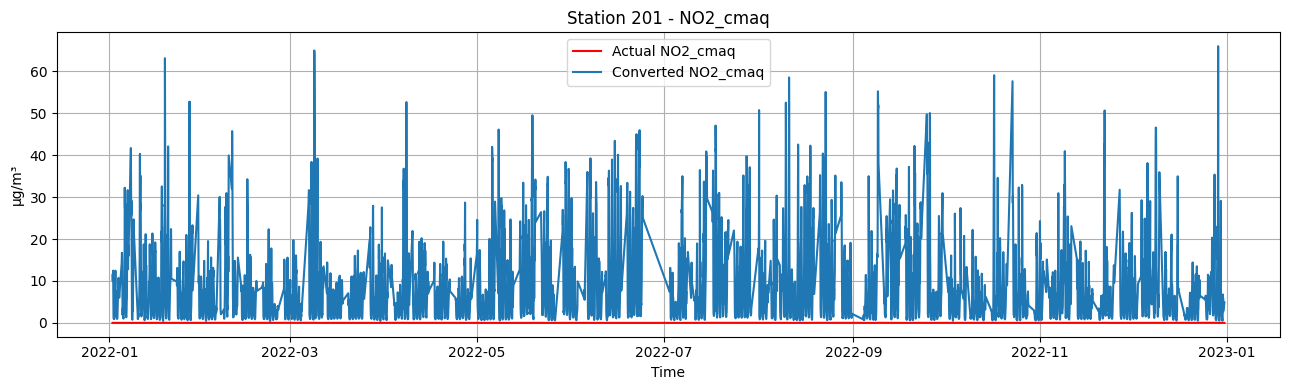

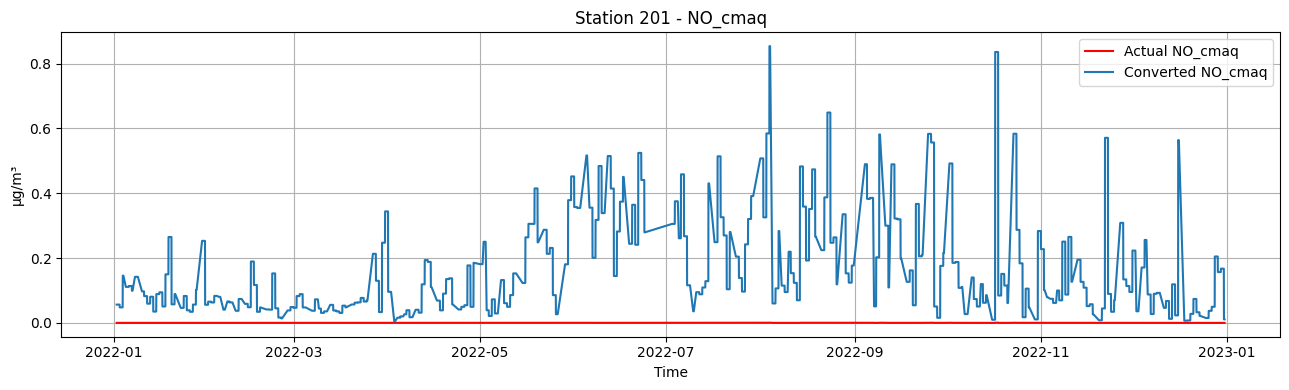

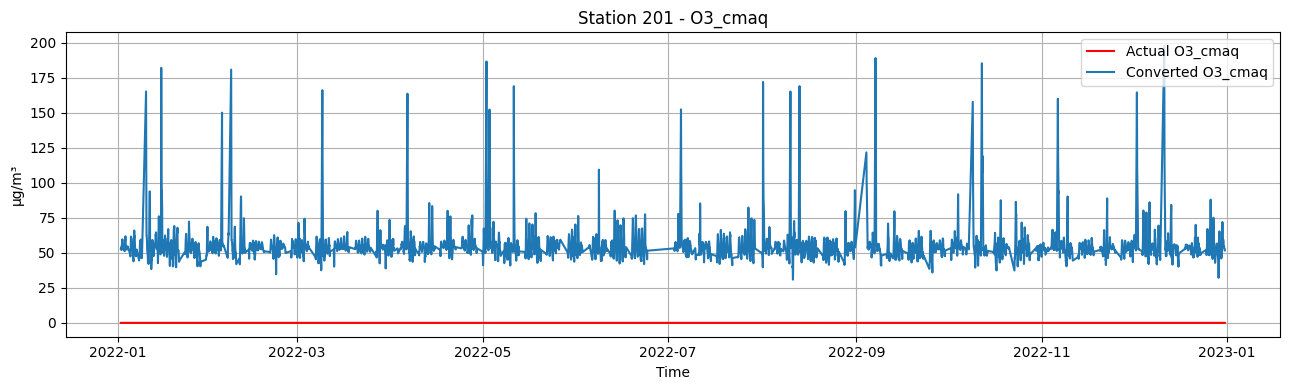

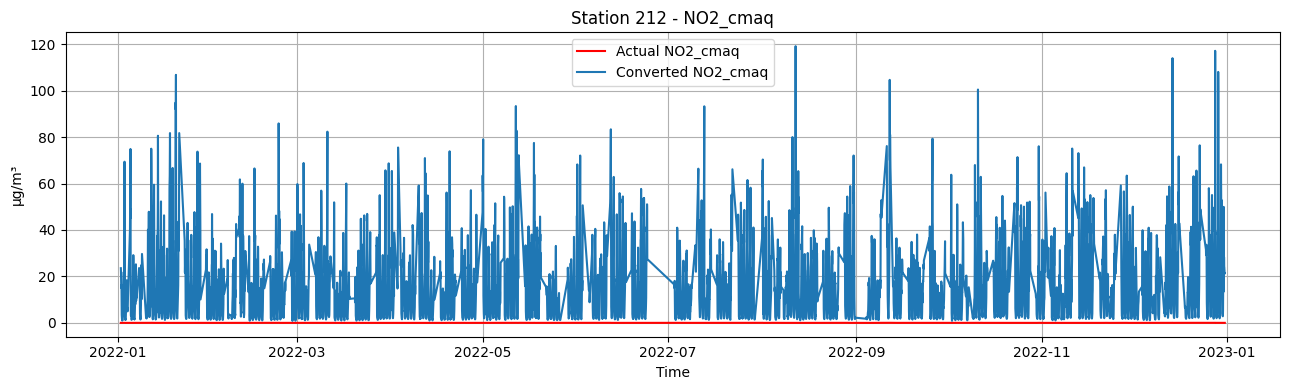

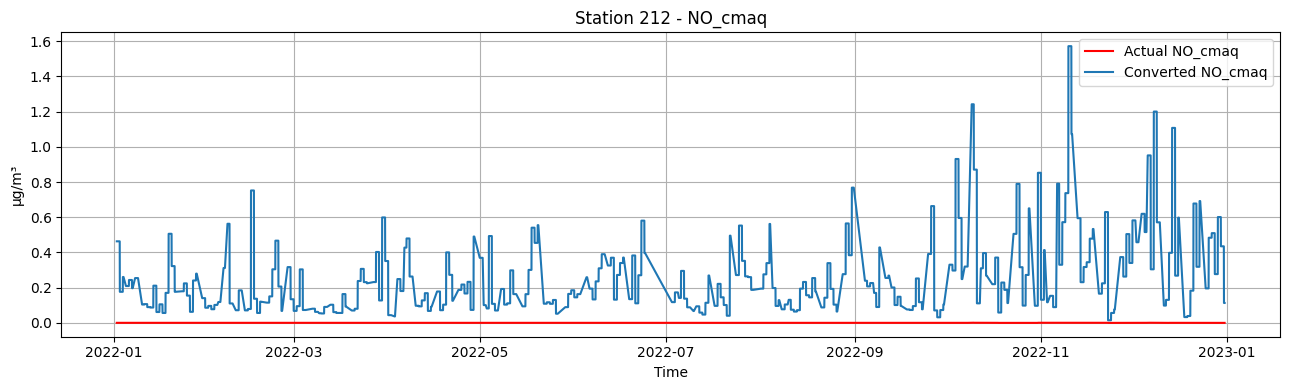

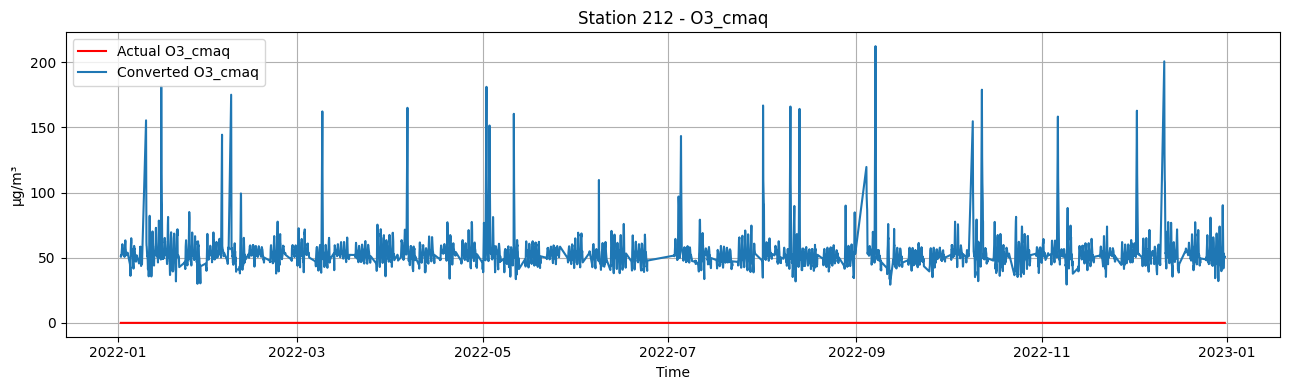

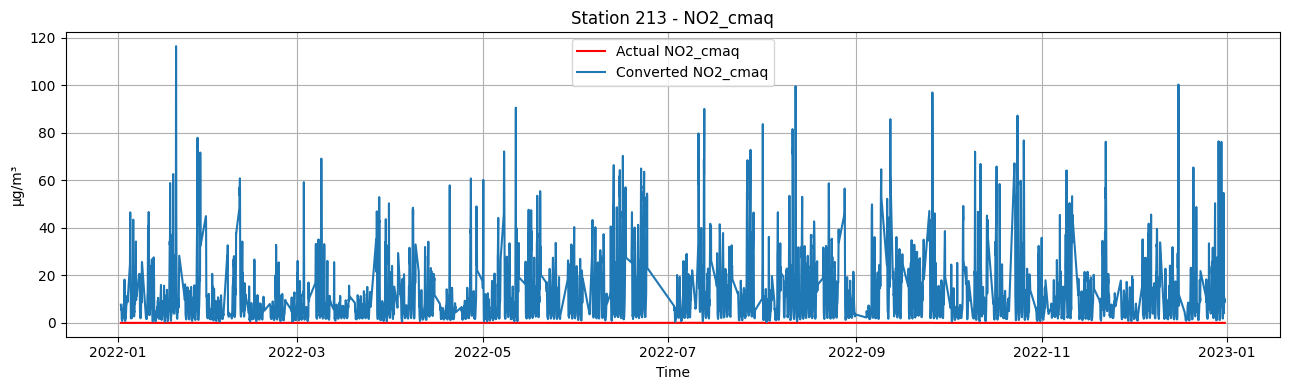

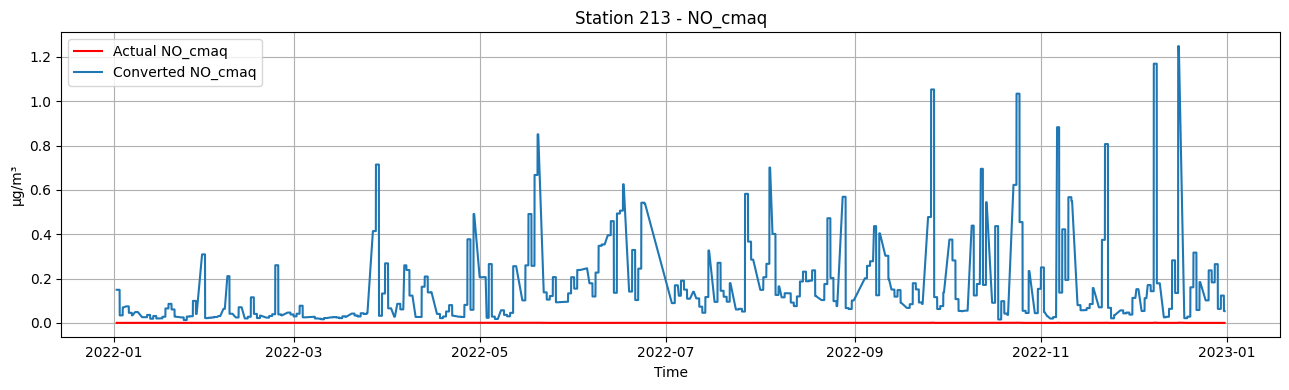

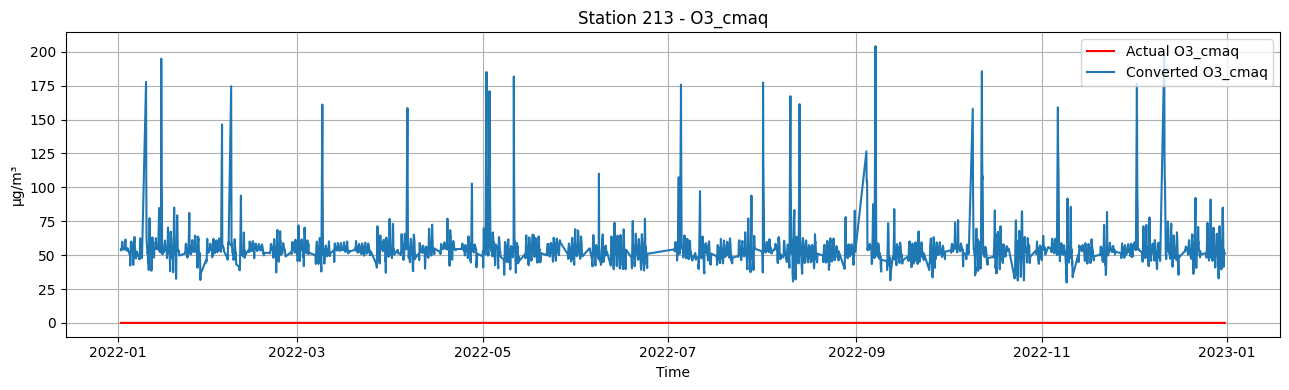

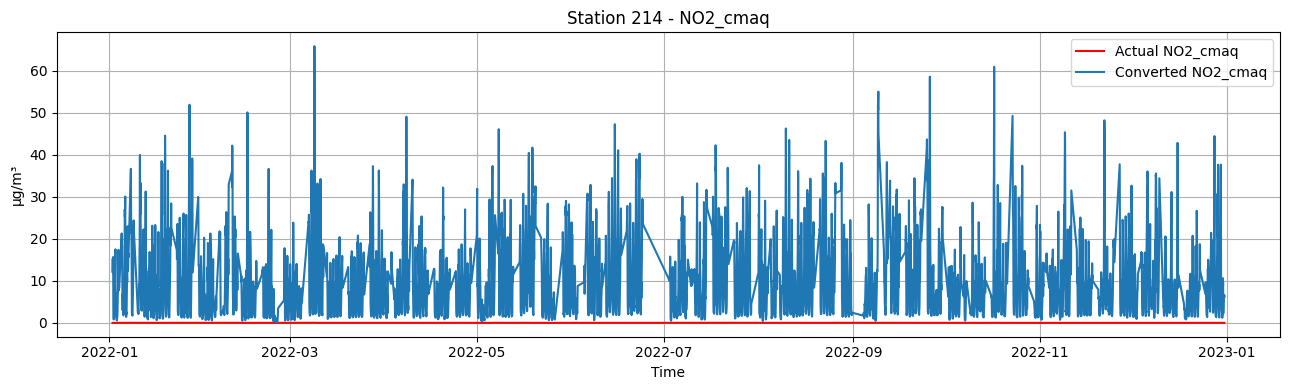

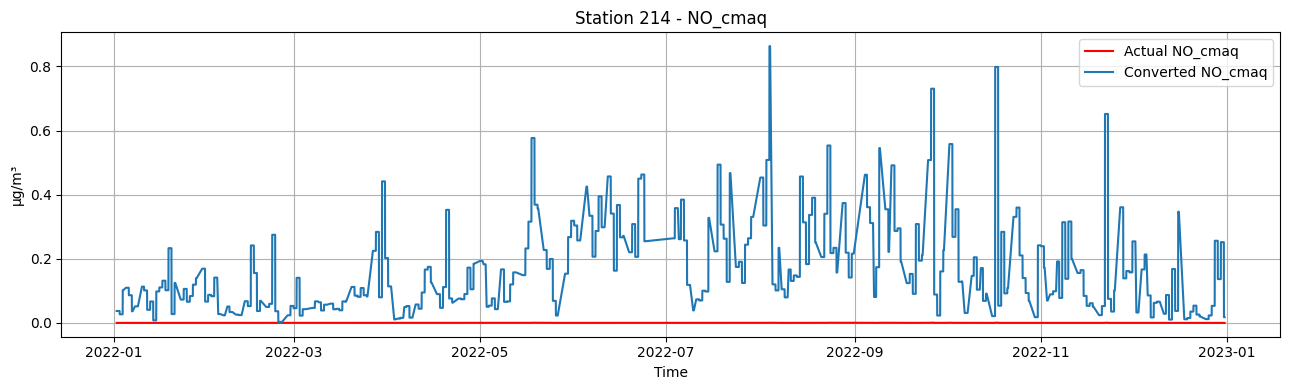

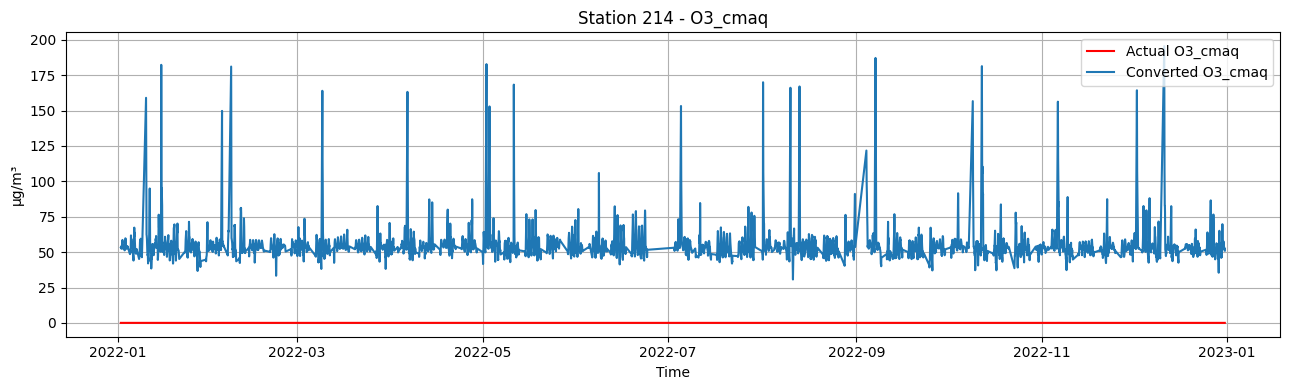

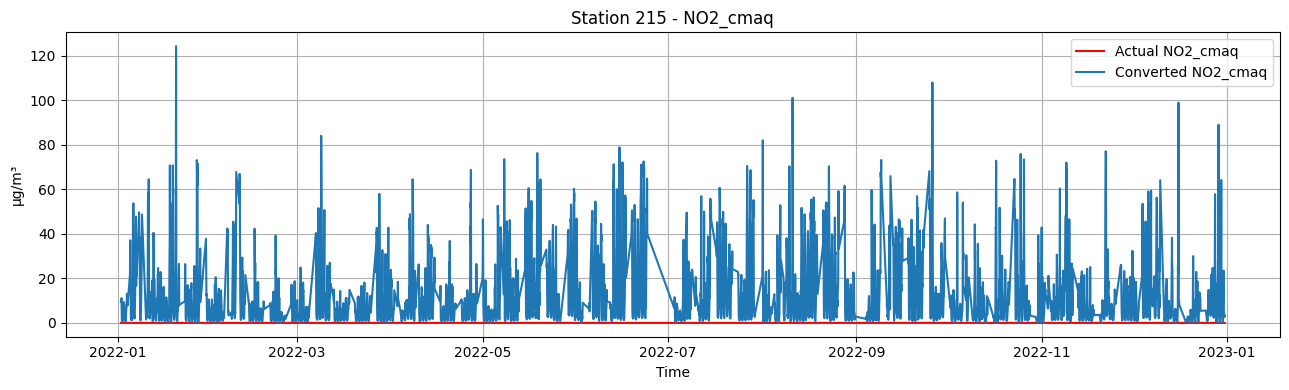

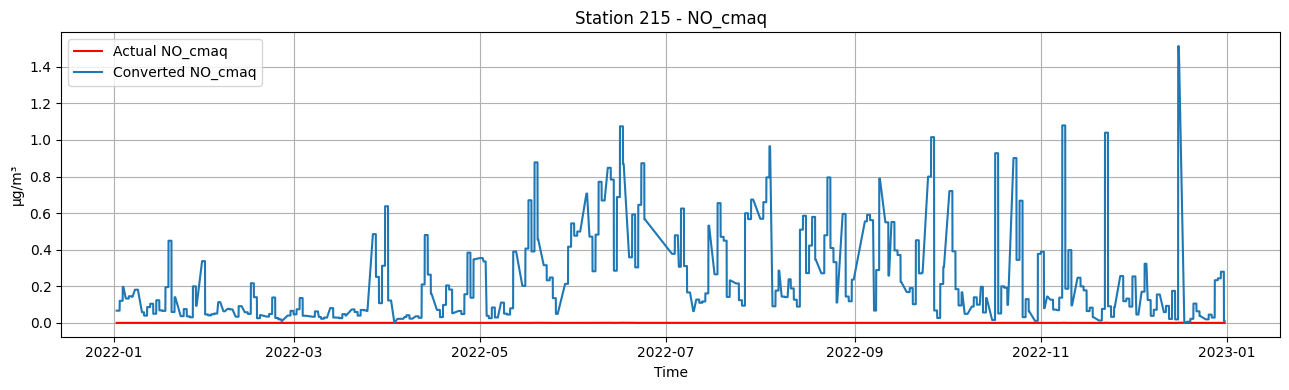

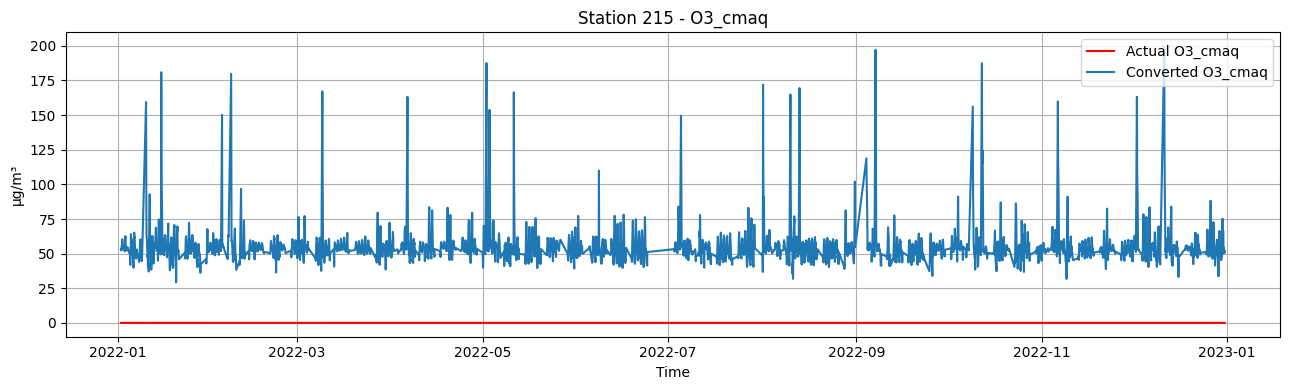

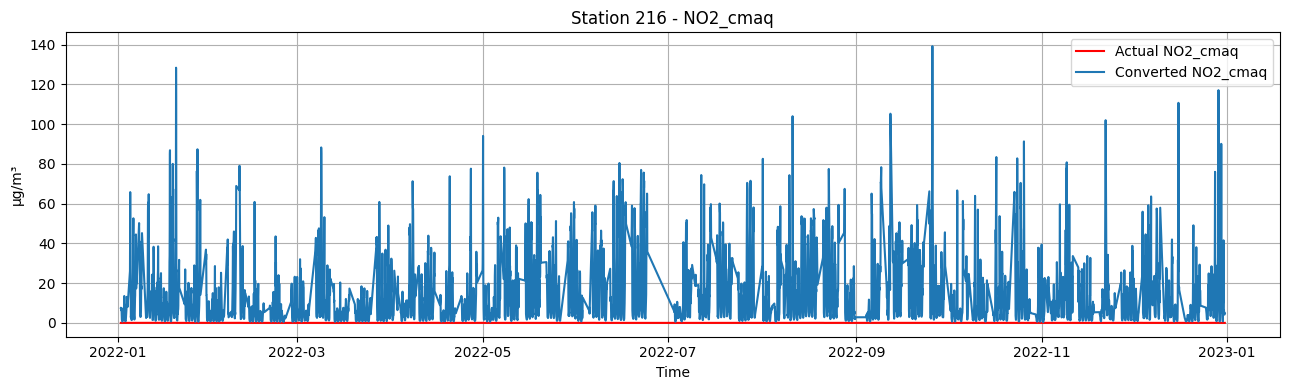

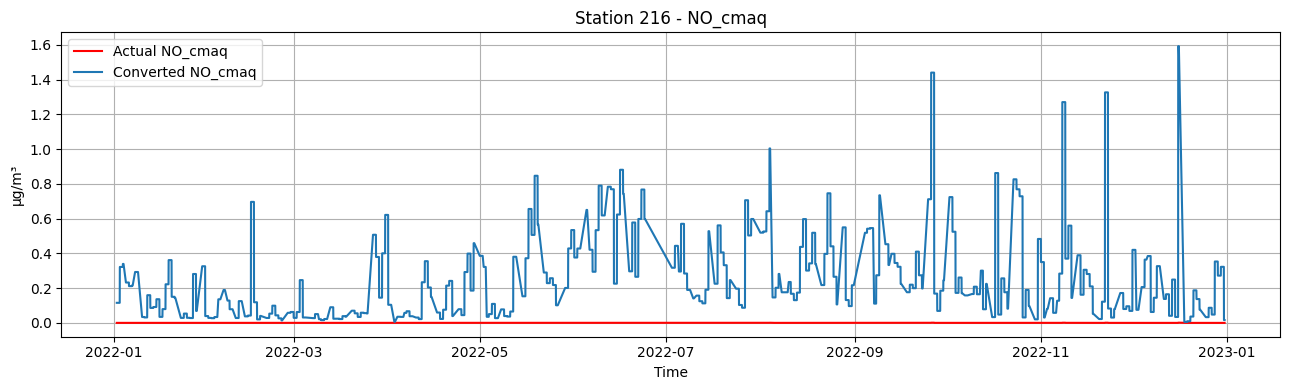

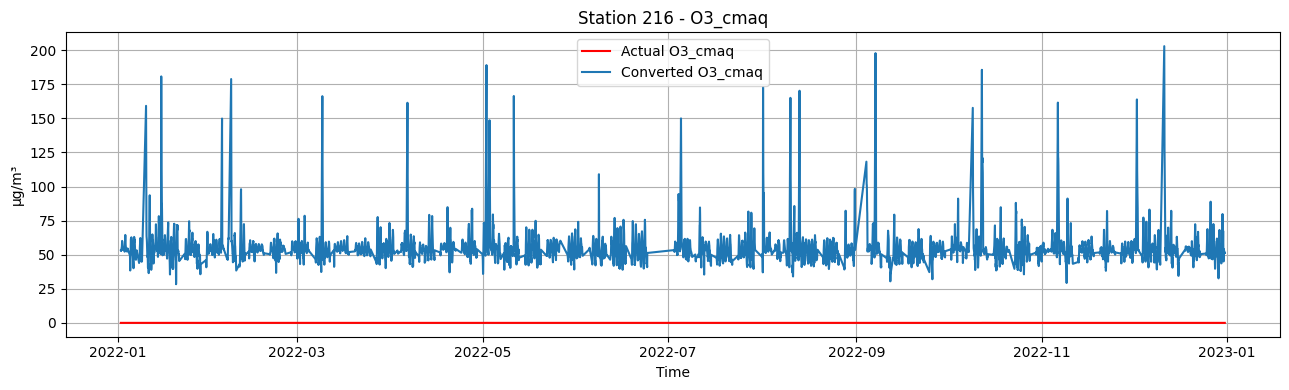

In [9]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [10]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 201
test201 = test[test["station_id"] == 201]
test = test.drop(index=test201[test201["NO2_cmaq"] > 40].index, errors="ignore")
#test = test.drop(index=test201[test201["NO_cmaq"] > 0.5].index, errors="ignore")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["NO2_cmaq"] > 80].index, errors="ignore")
#test = test.drop(index=test212[test212["NO_cmaq"] > 0.8].index, errors="ignore")

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["NO2_cmaq"] > 80].index, errors="ignore")
#test = test.drop(index=test213[test213["NO_cmaq"] > 0.8].index, errors="ignore")

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["NO2_cmaq"] > 50].index, errors="ignore")
#test = test.drop(index=test214[test214["NO_cmaq"] > 0.6].index, errors="ignore")

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_cmaq"] > 80].index, errors="ignore")
#test = test.drop(index=test215[test215["NO_cmaq"] > 0.8].index, errors="ignore")

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["NO2_cmaq"] > 80].index, errors="ignore")
#test = test.drop(index=test216[test216["NO_cmaq"] > 0.8].index, errors="ignore")

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 38310 records
After: 38140 records
Removed 170 records


## Visualization after removing outliers

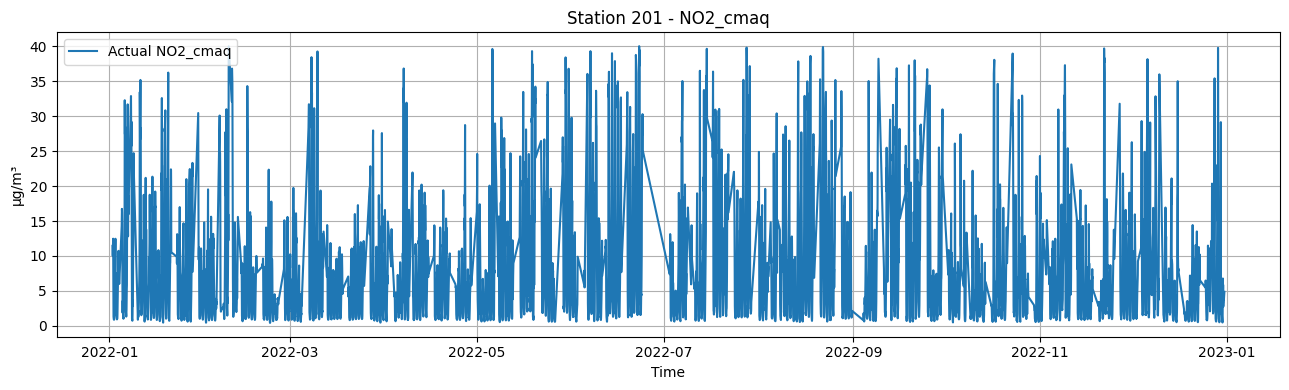

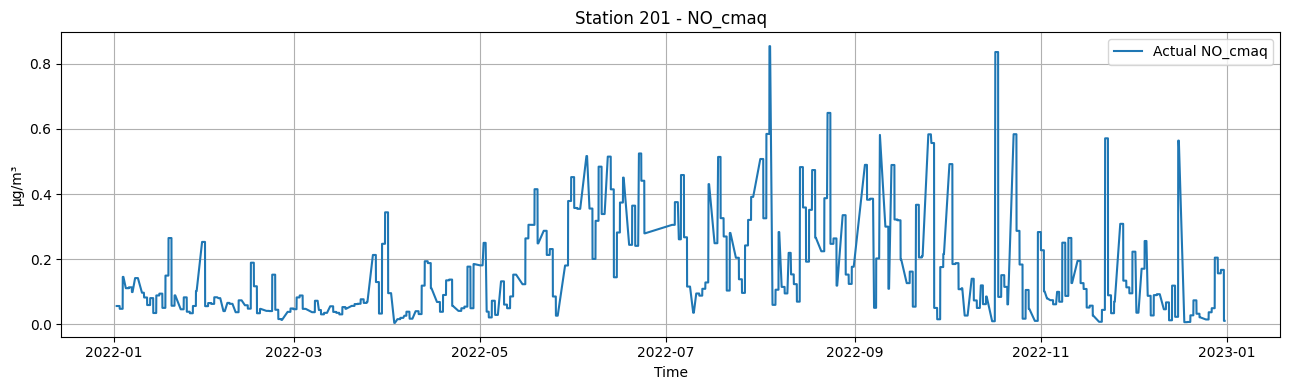

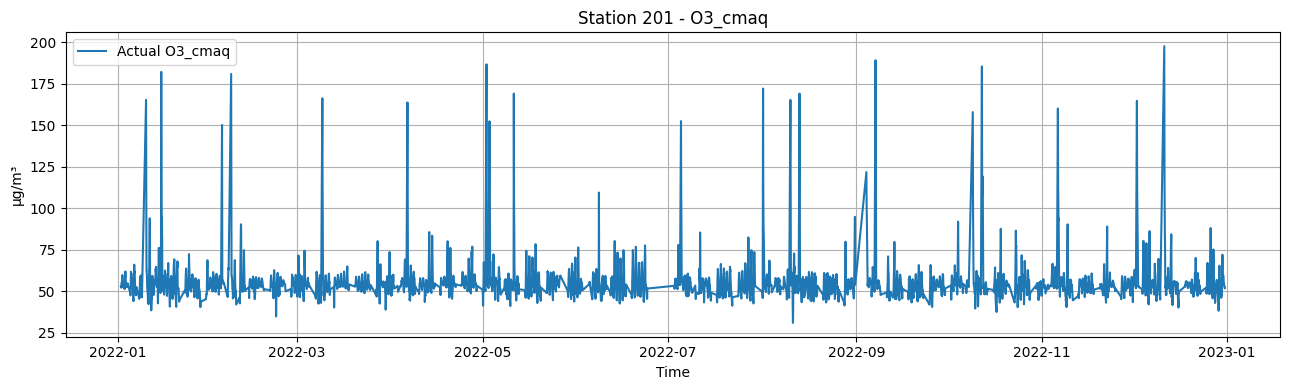

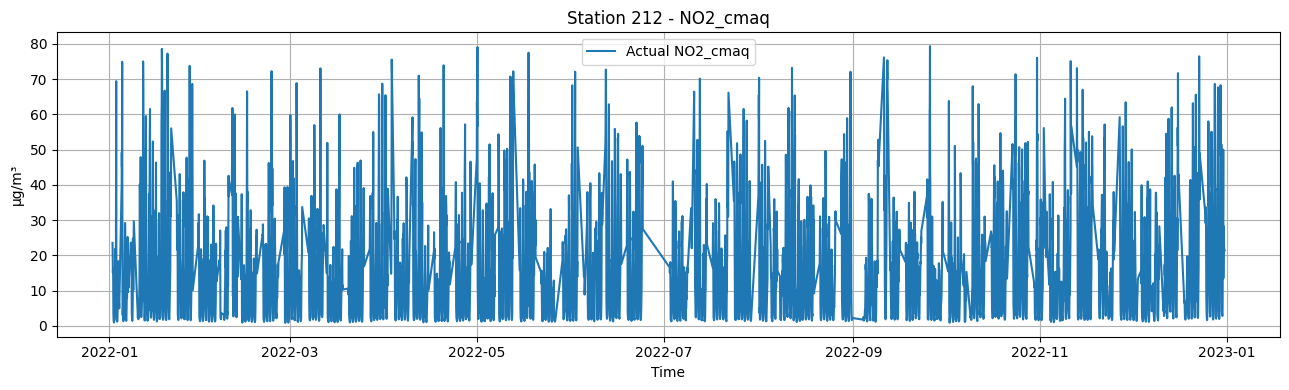

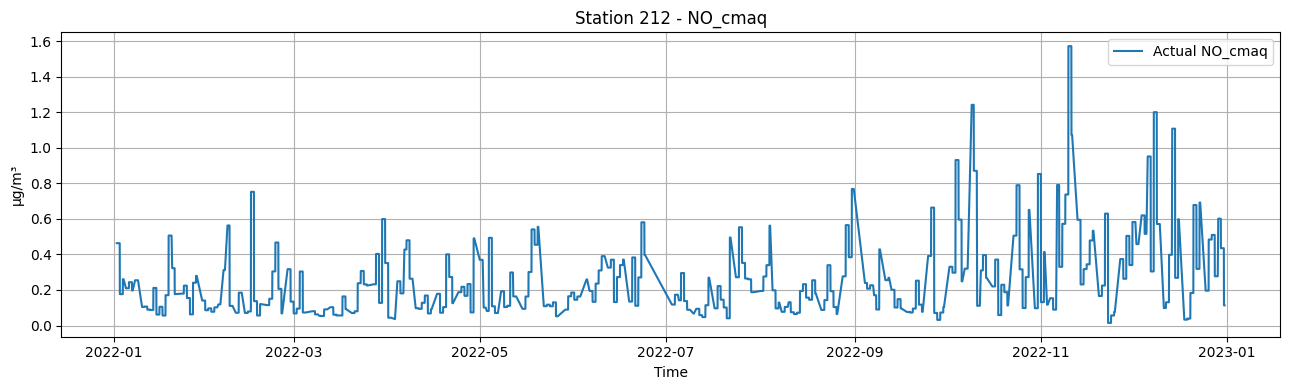

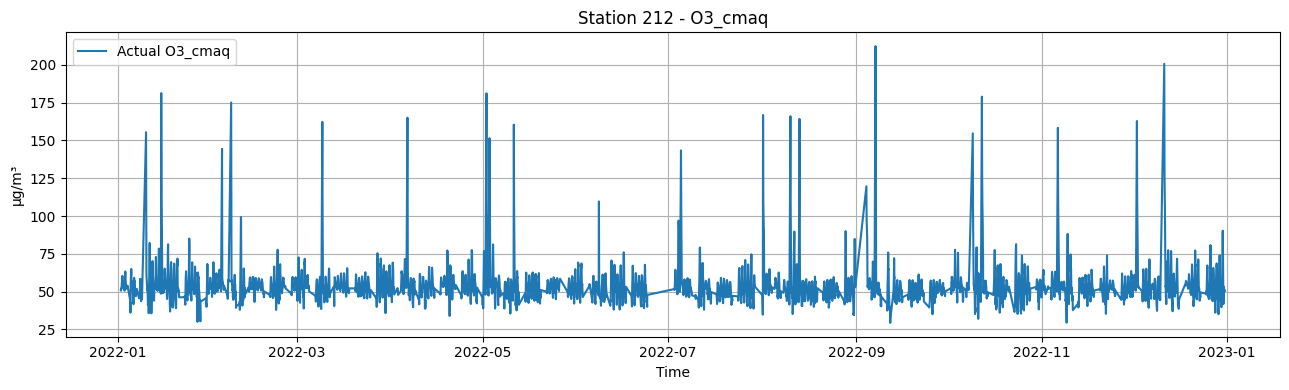

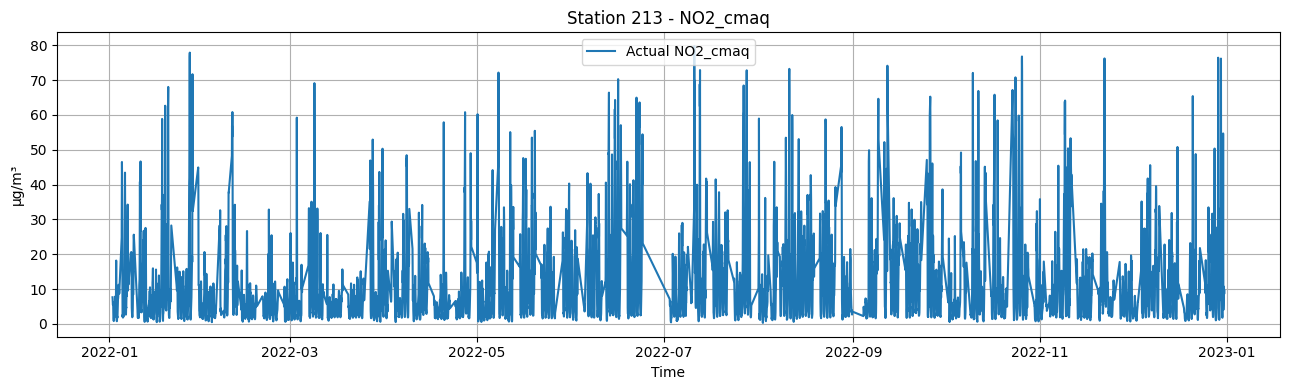

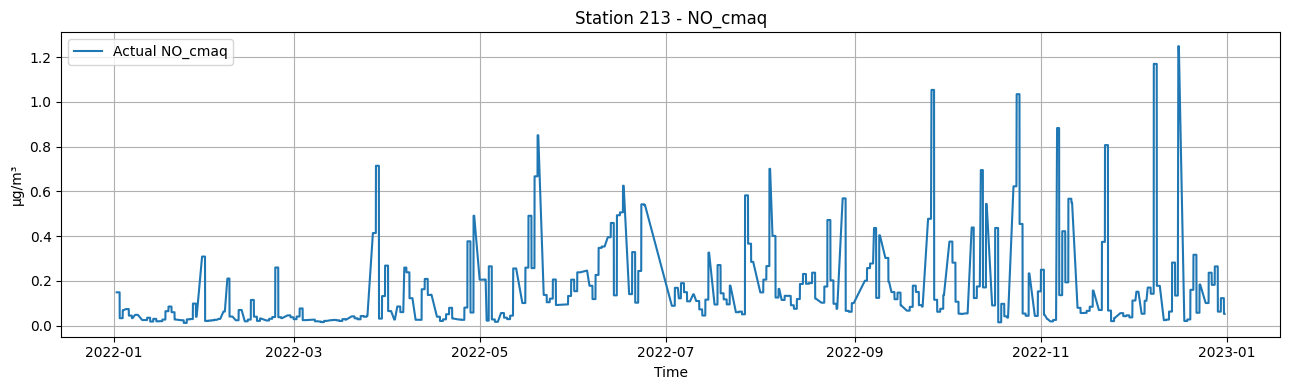

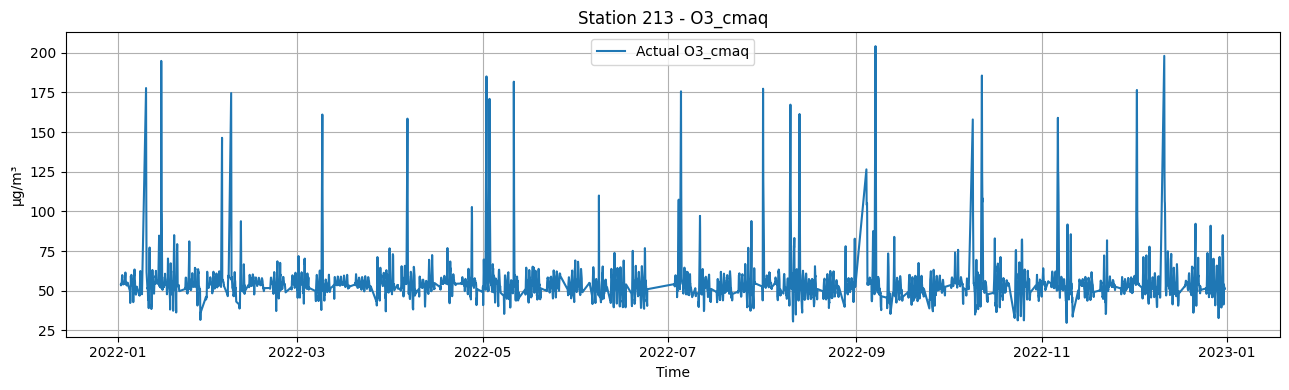

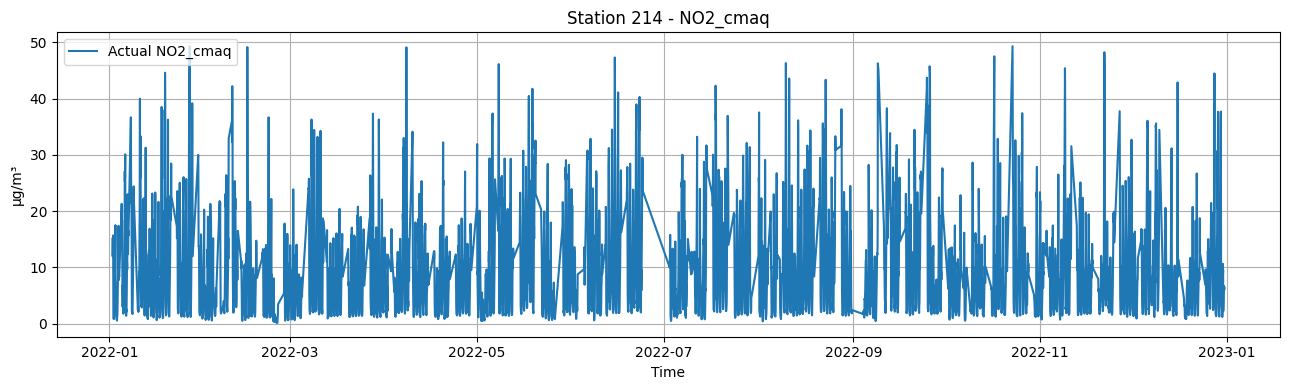

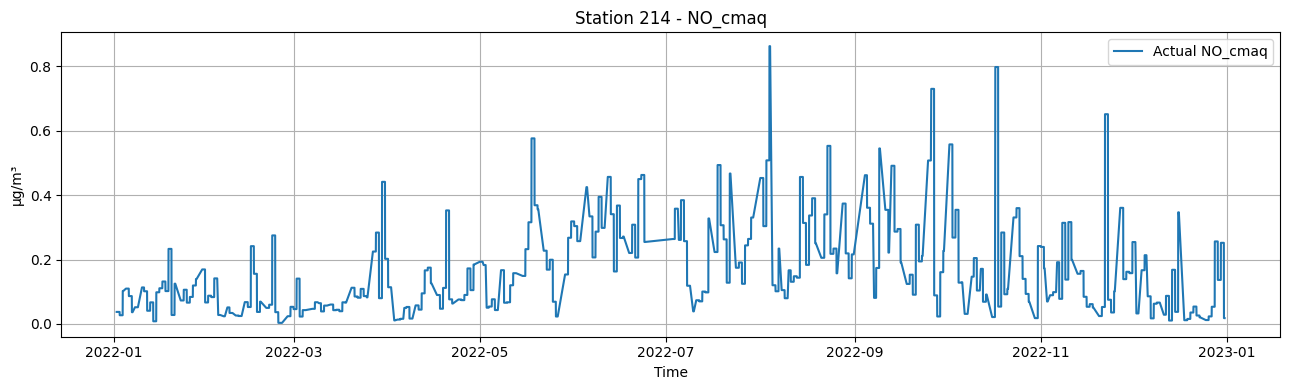

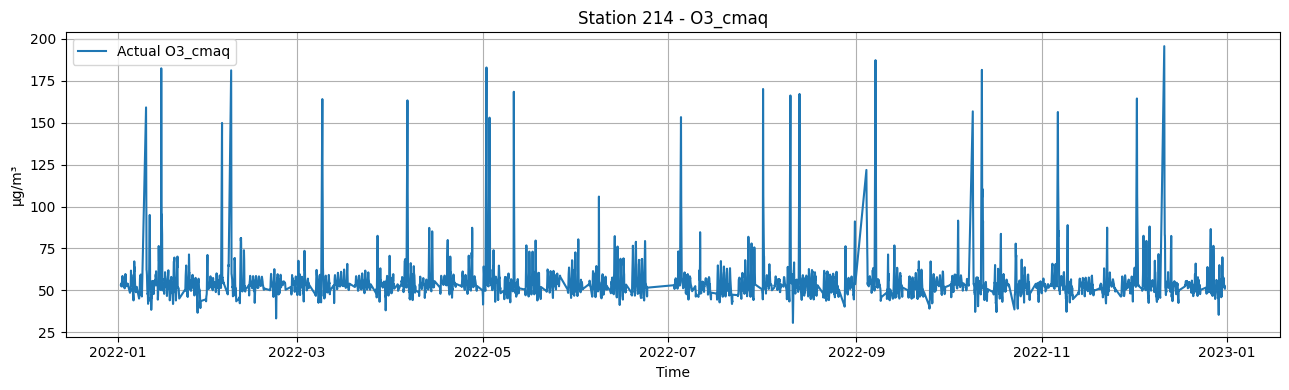

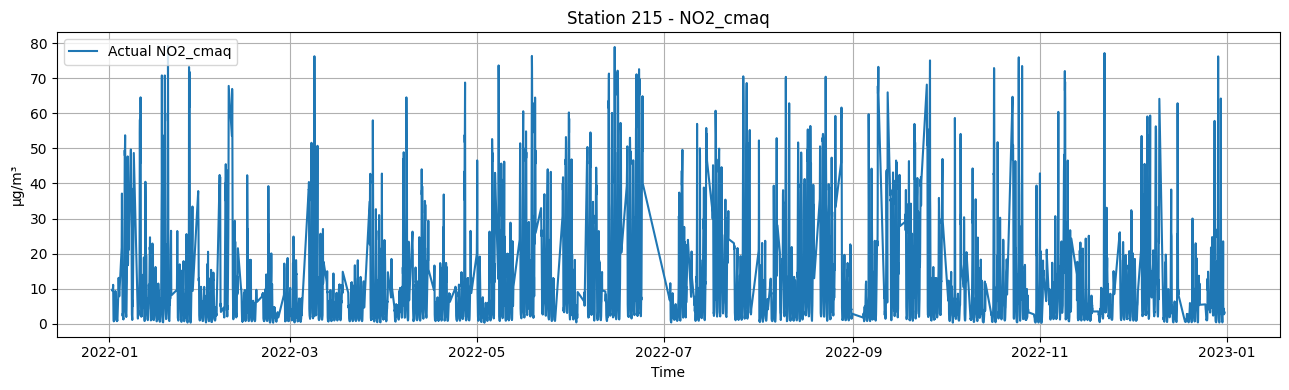

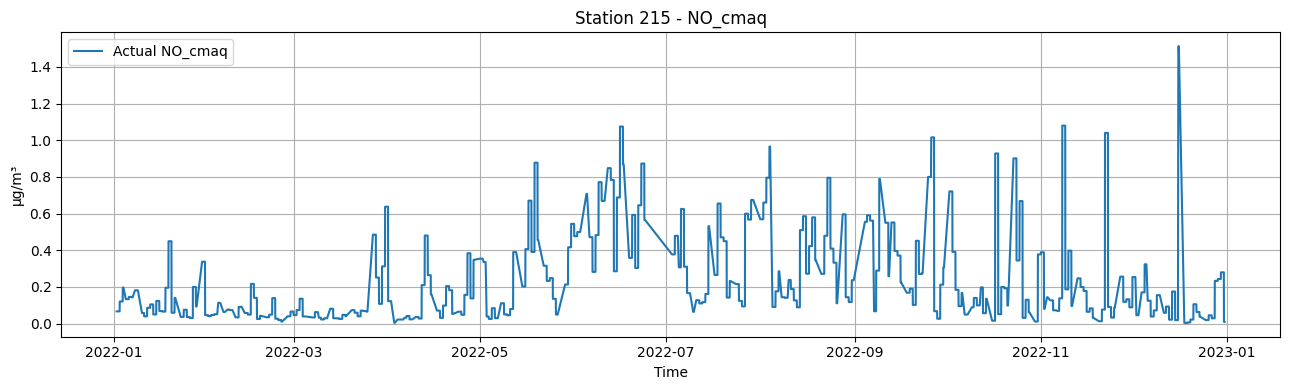

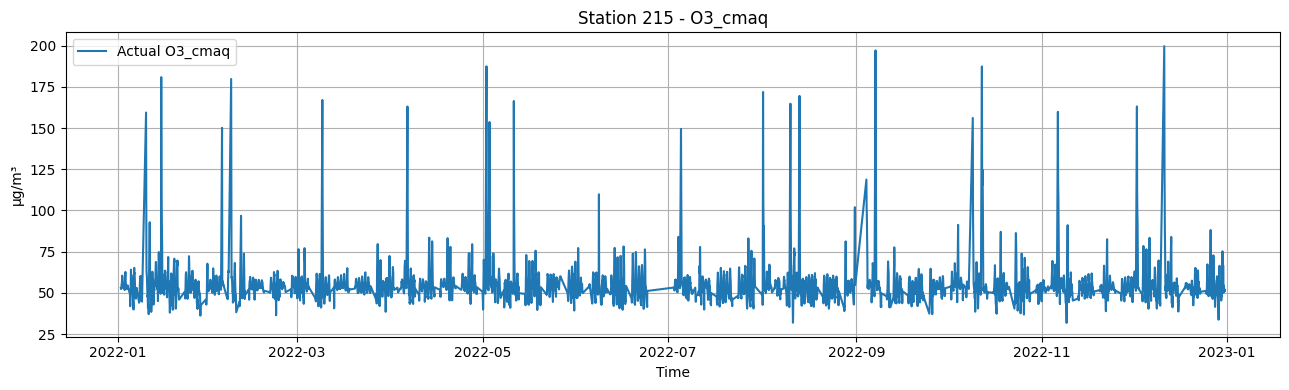

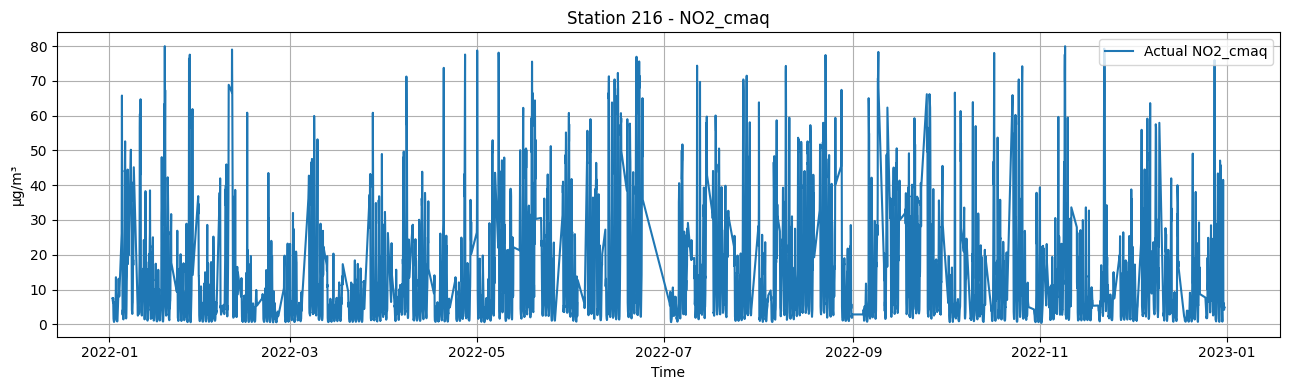

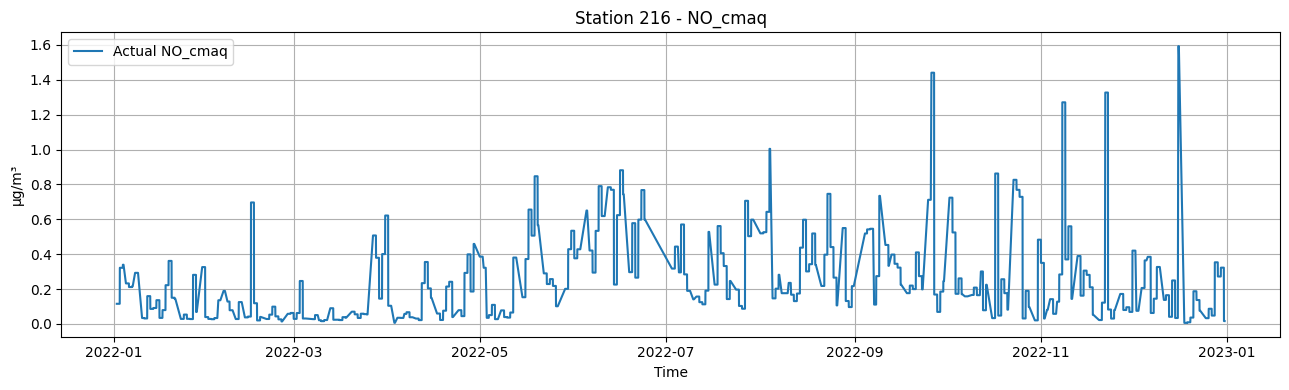

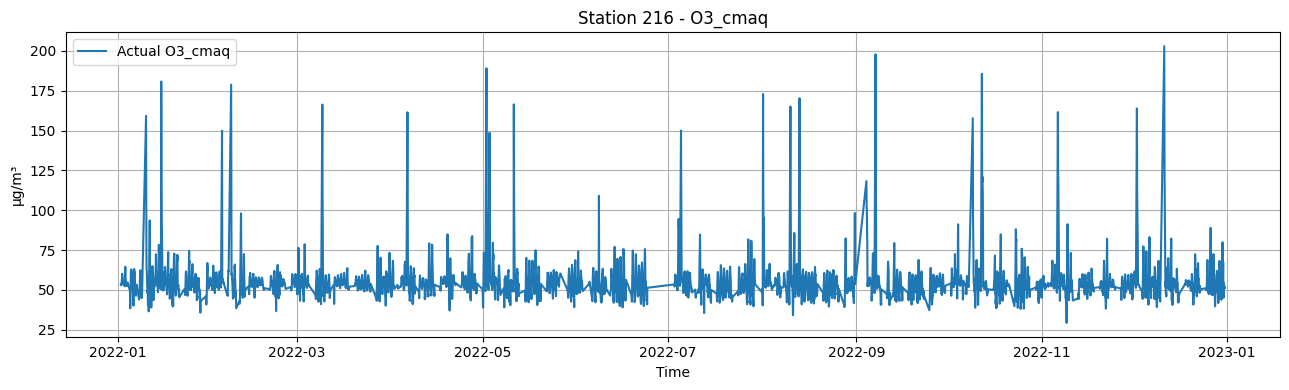

In [11]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

# Prepare test data with 73 records

In [12]:
df_test = df_converted.iloc[0:73]
df_test

date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id
0  2022-01-02 00:00:00  11.451346  0.056415  52.999082         201
1  2022-01-02 01:00:00  10.684879  0.056415  52.966078         201
2  2022-01-02 02:00:00  10.015549  0.056415  53.082975         201
3  2022-01-02 03:00:00  10.884442  0.056415  52.346179         201
4  2022-01-02 04:00:00  11.543206  0.056415  52.063844         201
..                 ...        ...       ...        ...         ...
68 2022-01-05 14:00:00   1.039444  0.111080  56.172144         201
69 2022-01-05 15:00:00   1.227818  0.111080  55.414206         201
70 2022-01-05 16:00:00   1.914248  0.111080  54.773903         201
71 2022-01-05 17:00:00   2.745578  0.111080  54.089040         201
72 2022-01-05 18:00:00   3.108947  0.111080  54.194204         201

[73 rows x 5 columns]

In [13]:
data = {}
for col in df_test.columns:
    new_col = col.lower().replace("_cmaq", "")
    data[new_col] = [str(item) for item in df_test[col].to_list()]

for k,v in data.items():
    print(f'"{k}": ', end='')
    if k == "date":
        formatted_items = [f'"{item}"' for item in v]
        print(f"[{', '.join(formatted_items)}]")
    else:
        formatted_items = [f'{item}' for item in v]
        print(f"[{', '.join(formatted_items)}]")
    print("\n")

"date": ["2022-01-02 00:00:00", "2022-01-02 01:00:00", "2022-01-02 02:00:00", "2022-01-02 03:00:00", "2022-01-02 04:00:00", "2022-01-02 05:00:00", "2022-01-02 06:00:00", "2022-01-02 07:00:00", "2022-01-02 08:00:00", "2022-01-02 09:00:00", "2022-01-02 10:00:00", "2022-01-02 11:00:00", "2022-01-02 12:00:00", "2022-01-02 13:00:00", "2022-01-02 14:00:00", "2022-01-02 15:00:00", "2022-01-02 16:00:00", "2022-01-02 17:00:00", "2022-01-02 18:00:00", "2022-01-02 19:00:00", "2022-01-02 20:00:00", "2022-01-02 21:00:00", "2022-01-02 22:00:00", "2022-01-02 23:00:00", "2022-01-03 00:00:00", "2022-01-03 01:00:00", "2022-01-03 02:00:00", "2022-01-03 03:00:00", "2022-01-03 04:00:00", "2022-01-03 05:00:00", "2022-01-03 06:00:00", "2022-01-03 07:00:00", "2022-01-03 08:00:00", "2022-01-03 09:00:00", "2022-01-03 10:00:00", "2022-01-03 11:00:00", "2022-01-03 12:00:00", "2022-01-03 13:00:00", "2022-01-03 14:00:00", "2022-01-03 15:00:00", "2022-01-03 16:00:00", "2022-01-03 17:00:00", "2022-01-03 18:00:00", "2

# LightGBM model

## Add time and lags features

In [14]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

display(df_lag_feats)
print(df_lag_feats.columns)

date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id  hour  \
0     2022-01-02 00:00:00  11.451346  0.056415  52.999082         201     0   
1     2022-01-02 01:00:00  10.684879  0.056415  52.966078         201     1   
2     2022-01-02 02:00:00  10.015549  0.056415  53.082975         201     2   
3     2022-01-02 03:00:00  10.884442  0.056415  52.346179         201     3   
4     2022-01-02 04:00:00  11.543206  0.056415  52.063844         201     4   
...                   ...        ...       ...        ...         ...   ...   
38135 2022-12-31 01:00:00   4.285888  0.016275  51.864199         216     1   
38136 2022-12-31 02:00:00   4.157322  0.016275  51.373838         216     2   
38137 2022-12-31 03:00:00   4.235773  0.016275  51.208808         216     3   
38138 2022-12-31 04:00:00   5.047855  0.016275  51.719656         216     4   
38139 2022-12-31 05:00:00   4.876919  0.016275  51.238619         216     5   

       dayofweek  month  NO2_cmaq_lag3  NO2_cmaq_lag6  ...  NO_cmaq_lag12  \
0              6      1            NaN            NaN  ...            NaN   
1              6      1            NaN            NaN  ...            NaN   
2              6      1            NaN            NaN  ...            NaN   
3              6      1      11.451346            NaN  ...            NaN   
4              6      1      10.684879            NaN  ...            NaN   
...          ...    ...            ...            ...  ...            ...   
38135          5     12       5.647730      41.518873  ...        0.32275   
38136          5     12       6.105911      12.065706  ...        0.32275   
38137          5     12       4.859500       4.619153  ...        0.32275   
38138          5     12       4.285888       5.647730  ...        0.32275   
38139          5     12       4.157322       6.105911  ...        0.32275   

       NO_cmaq_lag24  NO_cmaq_lag48  NO_cmaq_lag72  O3_cmaq_lag3  \
0                NaN            NaN            NaN           NaN   
1                NaN            NaN            NaN           NaN   
2                NaN            NaN            NaN           NaN   
3                NaN            NaN            NaN     52.999082   
4                NaN            NaN            NaN     52.966078   
...              ...            ...            ...           ...   
38135        0.32275       0.353378       0.047921     53.601819   
38136        0.32275       0.353378       0.047921     53.091954   
38137        0.32275       0.272093       0.353378     52.506960   
38138        0.32275       0.272093       0.353378     51.864199   
38139        0.32275       0.272093       0.353378     51.373838   

       O3_cmaq_lag6  O3_cmaq_lag12  O3_cmaq_lag24  O3_cmaq_lag48  \
0               NaN            NaN            NaN            NaN   
1               NaN            NaN            NaN            NaN   
2               NaN            NaN            NaN            NaN   
3               NaN            NaN            NaN            NaN   
4               NaN            NaN            NaN            NaN   
...             ...            ...            ...            ...   
38135     45.059627      57.843731      48.583712      47.583632   
38136     52.639822      56.219246      43.799701      47.278841   
38137     54.140788      65.605684      48.965382      43.650907   
38138     53.601819      67.474872      49.118889      41.732540   
38139     53.091954      58.288197      48.376421      41.760297   

       O3_cmaq_lag72  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
38135      46.964828  
38136      43.286708  
38137      39.717634  
38138      41.230542  
38139      44.223159  

[38140 rows x 26 columns]

Index(['date', 'NO2_cmaq', 'NO_cmaq', 'O3_cmaq', 'station_id', 'hour',
       'dayofweek', 'month', 'NO2_cmaq_lag3', 'NO2_cmaq_lag6',
       'NO2_cmaq_lag12', 'NO2_cmaq_lag24', 'NO2_cmaq_lag48', 'NO2_cmaq_lag72',
       'NO_cmaq_lag3', 'NO_cmaq_lag6', 'NO_cmaq_lag12', 'NO_cmaq_lag24',
       'NO_cmaq_lag48', 'NO_cmaq_lag72', 'O3_cmaq_lag3', 'O3_cmaq_lag6',
       'O3_cmaq_lag12', 'O3_cmaq_lag24', 'O3_cmaq_lag48', 'O3_cmaq_lag72'],
      dtype='object')


## Training for NO_cmaq

In [15]:
# Add rolling features for target_col
target_col = "NO_cmaq"
df_no = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_station_embedding.pkl"), "rb") as no_emb_file:
    no_station_to_embedding = pickle.load(no_emb_file)
print(no_station_to_embedding)
df_no, _ = attach_station_embedding(df_no, no_station_to_embedding, station_col="station_id")

# Dropna
df_no = df_no.dropna()
display(df_no)

for horizon_h in HORIZONS:
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_lightgbm_{horizon_h}h"))
    predicted_value = test_model.predict(df_no.drop(columns=["station_id", "date", target_col]), num_iteration=getattr(test_model, "best_iteration", None))[0]
    print(f"Horizon: {horizon_h}h - predicted: {predicted_value}")

{201: [1.986529, 1.2916492, 1.0195599, -1.9552311], 212: [1.055678, -1.4085163, 0.1929041, -1.2646787], 213: [-0.3146515, -0.1838045, -0.91504866, -0.38648748], 214: [-0.72265536, -0.14680372, -2.0384333, 0.094024025], 215: [-0.13111751, -0.32316387, 0.6650374, -0.42779222], 216: [-0.6735614, -0.088721246, -0.68943256, 0.22807519]}


date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id  hour  \
72    2022-01-05 18:00:00   3.108947  0.111080  54.194204         201    18   
73    2022-01-05 19:00:00   3.787343  0.111080  54.242578         201    19   
74    2022-01-05 20:00:00   5.230298  0.111080  53.521391         201    20   
75    2022-01-05 21:00:00   6.475460  0.111080  53.157180         201    21   
76    2022-01-05 22:00:00  11.666098  0.111080  51.422047         201    22   
...                   ...        ...       ...        ...         ...   ...   
38135 2022-12-31 01:00:00   4.285888  0.016275  51.864199         216     1   
38136 2022-12-31 02:00:00   4.157322  0.016275  51.373838         216     2   
38137 2022-12-31 03:00:00   4.235773  0.016275  51.208808         216     3   
38138 2022-12-31 04:00:00   5.047855  0.016275  51.719656         216     4   
38139 2022-12-31 05:00:00   4.876919  0.016275  51.238619         216     5   

       dayofweek  month  NO2_cmaq_lag3  NO2_cmaq_lag6  ...  \
72             2      1       1.227818       1.192680  ...   
73             2      1       1.914248       1.170812  ...   
74             2      1       2.745578       1.039444  ...   
75             2      1       3.108947       1.227818  ...   
76             2      1       3.787343       1.914248  ...   
...          ...    ...            ...            ...  ...   
38135          5     12       5.647730      41.518873  ...   
38136          5     12       6.105911      12.065706  ...   
38137          5     12       4.859500       4.619153  ...   
38138          5     12       4.285888       5.647730  ...   
38139          5     12       4.157322       6.105911  ...   

       NO_cmaq_roll24_mean  NO_cmaq_roll24_std  NO_cmaq_roll48_mean  \
72                0.119750            0.015340             0.083805   
73                0.118305            0.014387             0.085122   
74                0.116860            0.013202             0.086439   
75                0.115415            0.011716             0.087756   
76                0.113970            0.009791             0.089073   
...                    ...                 ...                  ...   
38135             0.309980            0.062559             0.294423   
38136             0.297210            0.086527             0.287400   
38137             0.284441            0.103537             0.280377   
38138             0.271671            0.116673             0.275048   
38139             0.258901            0.127142             0.269718   

       NO_cmaq_roll48_std  NO_cmaq_roll72_mean  NO_cmaq_roll72_std  \
72               0.037877             0.074675            0.033448   
73               0.037699             0.075434            0.033647   
74               0.037473             0.076194            0.033828   
75               0.037198             0.076953            0.033991   
76               0.036873             0.077712            0.034136   
...                   ...                  ...                 ...   
38135            0.049194             0.305590            0.065301   
38136            0.062784             0.305151            0.067140   
38137            0.073232             0.304711            0.068928   
38138            0.082562             0.300029            0.076598   
38139            0.090620             0.295347            0.083300   

       station_emb_0  station_emb_1  station_emb_2  station_emb_3  
72          1.986529       1.291649       1.019560      -1.955231  
73          1.986529       1.291649       1.019560      -1.955231  
74          1.986529       1.291649       1.019560      -1.955231  
75          1.986529       1.291649       1.019560      -1.955231  
76          1.986529       1.291649       1.019560      -1.955231  
...              ...            ...            ...            ...  
38135      -0.673561      -0.088721      -0.689433       0.228075  
38136      -0.673561      -0.088721      -0.689433       0.228075  
38137      -0.673561 

Horizon: 1h - predicted: 0.11326403401165332
Horizon: 24h - predicted: 0.11558056414724269
Horizon: 48h - predicted: 0.1711844007339671
Horizon: 72h - predicted: 0.14010269293966987
